# $\text{Importing necessary packages}$

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import optuna
import seaborn as sns
import random
import pandas as pd
import json

from tensorflow.keras.datasets import mnist 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier   
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from PIL import Image

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.utils import to_categorical 
import itertools
import os

## $\text{Necessary Functions}$

In [2]:
# Creating the data set function
def generate_paired_data(images, labels, seed=None):
    """
    Generates paired images and labels, while keeping track of individual images and labels.

    Parameters:
        images (numpy.ndarray): Array of images, shape (num_samples, height, width).
        labels (numpy.ndarray): Array of labels, shape (num_samples,).
        seed (int, optional): Seed for reproducibility.

    Returns:
        paired_images (numpy.ndarray): Array of vertically stacked paired images, shape (num_pairs, height*2, width).
        paired_labels (numpy.ndarray): Array of paired labels (sum of the labels of the two images), shape (num_pairs,).
        first_images (numpy.ndarray): Array of the first images in each pair, shape (num_pairs, height, width).
        second_images (numpy.ndarray): Array of the second images in each pair, shape (num_pairs, height, width).
        first_labels (numpy.ndarray): Array of labels for the first images in each pair, shape (num_pairs,).
        second_labels (numpy.ndarray): Array of labels for the second images in each pair, shape (num_pairs,).
    """
    if seed is not None:
        np.random.seed(seed)

    num_pairs = len(images)
    paired_images = []
    paired_labels = []
    first_images = []
    second_images = []
    first_labels = []
    second_labels = []

    for _ in range(num_pairs):
        # Randomly choosing two indices with replacement
        idx1 = np.random.randint(0, len(images))
        idx2 = np.random.randint(0, len(images))

        # Stacking images vertically
        combined_image = np.vstack((images[idx1], images[idx2]))
        paired_images.append(combined_image)

        # Labeling is the sum of the labels of the two images
        combined_label = labels[idx1] + labels[idx2]
        paired_labels.append(combined_label)

        # Tracking individual images and their labels
        first_images.append(images[idx1])
        second_images.append(images[idx2])
        first_labels.append(labels[idx1])
        second_labels.append(labels[idx2])

    paired_images = np.array(paired_images)
    paired_labels = np.array(paired_labels)
    first_images = np.array(first_images)
    second_images = np.array(second_images)
    first_labels = np.array(first_labels)
    second_labels = np.array(second_labels)

    return paired_images, paired_labels, first_images, second_images, first_labels, second_labels


In [3]:
# Displaying images function
def display_images(images, labels, num_images=50, cmap='gray', figsize=(20, 10), main_title=None, y=0.9):
    """
    Displays paired images with their labels.
    
    Parameters:
        images (numpy.ndarray): Array of paired images, shape (num_samples, height, width).
        labels (numpy.ndarray): Array of paired labels, shape (num_samples,).
        num_images (int, optional): Number of images to display. Default is 50.
        cmap (str, optional): Colormap for displaying images. Default is 'gray'.
        figsize (tuple, optional): Size of the figure. Default is (20, 10).
    """
    num_images = min(num_images, len(images))  # Ensuring we don't exceed available images
    plt.figure(figsize=figsize)

    if main_title:
        plt.suptitle(main_title, fontsize=16, y=y) 
    
    for i in range(num_images):
        plt.subplot((num_images + 9) // 10, 10, i + 1)  # Arrange in rows of 10
        plt.imshow(images[i], cmap=cmap)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [4]:
# Plotting label distribution function
def plot_label_distribution(labels, title="Label Distribution", xlabel="Label", ylabel="Frequency", figsize=(10, 6)):
    """
    Plots a bar chart showing the distribution of labels.
    
    Parameters:
        labels (numpy.ndarray): Array of labels for which to calculate the distribution.
        title (str, optional): Title of the chart. Default is "Label Distribution".
        xlabel (str, optional): Label for the x-axis. Default is "Label".
        ylabel (str, optional): Label for the y-axis. Default is "Frequency".
        figsize (tuple, optional): Figure size. Default is (10, 6).
    """
    # Count the occurrences of each label
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Create the bar chart
    plt.figure(figsize=figsize)
    plt.bar(unique_labels, counts, edgecolor="black", alpha=0.7)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(unique_labels)  # Set x-axis ticks to unique label values
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Adding the counts above each bar
    for i, count in enumerate(counts):
        plt.text(unique_labels[i], count + 0.5, str(count), ha='center', fontsize=12)
    
    plt.show()

In [5]:
# Plotting function
def plot_training_results(history, test_accuracy, test_loss, model_number=None):
    """
    Plots the training and validation accuracy/loss curves along with the test accuracy and loss.

    Args:
        history (History): The history object returned by the model's `fit()` method, containing the training/validation metrics.
        test_accuracy (float): The test accuracy to be displayed as a horizontal line.
        test_loss (float): The test loss to be displayed as a horizontal line.
        model_number (int, optional): An optional model identifier for the plot title. Default is None.

    Displays:
        Two plots:
            - One for accuracy (training vs validation) with test accuracy.
    """ 
    # Extract training and validation metrics
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # plot Accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.4f}')
    plt.title(f'Model {model_number} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot Loss
    plt.figure(figsize=(7, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
    plt.title(f'Model {model_number} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# Printing validation and test accuracies function
def evaluate_and_return_results(model, paired_images_val, paired_labels_val, paired_images_test, paired_labels_test):
    """
    Evaluates the model on both the validation and test sets and prints the results.

    Args:
        model (tf.keras.Model): The trained Keras model to be evaluated.
        paired_images_val (numpy.ndarray): The validation images (input data) for evaluation.
        paired_labels_val (numpy.ndarray): The labels corresponding to the validation images.
        paired_images_test (numpy.ndarray): The test images (input data) for evaluation.
        paired_labels_test (numpy.ndarray): The labels corresponding to the test images.

    Returns:
        tuple: The test loss and test accuracy as a tuple (test_loss, test_accuracy).
    """

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(paired_images_val, paired_labels_val)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(paired_images_test, paired_labels_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    return test_loss, test_accuracy

# Confusion matrix function
def plot_confusion_matrix(true_classes, predicted_classes, num_classes=19):
    """
    Plots a confusion matrix to visualize the performance of a classifier.

    Args:
        true_classes (array-like): The true class labels for the data.
        predicted_classes (array-like): The predicted class labels for the data.
        num_classes (int, optional): The number of unique classes. Default is 19.

    Displays:
        A heatmap of the confusion matrix with annotations for each cell.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(9,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [6]:
def evaluate_predictions(model, test_images, true_labels, top_n=10):
    """
    Evaluates model predictions and compares them with true labels.
    
    Parameters:
        model (tensorflow.keras.Model): The trained model to make predictions.
        test_images (numpy.ndarray): Array of test images.
        true_labels (numpy.ndarray): Array of true labels.
        top_n (int, optional): Number of predictions to display for comparison. Default is 10.
    
    Returns:
        predicted_classes (numpy.ndarray): Predicted class labels.
        true_classes (numpy.ndarray): True class labels.
    """
    # Predict probabilities for each class
    predictions = model.predict(test_images)

    # Convert probabilities to class labels
    predicted_classes = predictions.argmax(axis=1)  # Get class with the highest probability

    # Display a sample of predictions and true labels
    print("Predicted Classes:", predicted_classes[:top_n])
    print("True Classes:", true_labels[:top_n])

    return predicted_classes, true_labels

In [7]:
def plot_predictions(images, predicted_classes, true_classes, num_images=10, cmap='gray', figsize=(19, 5)):
    """
    Plots test images with their predicted and true labels.
    
    Parameters:
        images (numpy.ndarray): Array of test images.
        predicted_classes (numpy.ndarray): Array of predicted class labels.
        true_classes (numpy.ndarray): Array of true class labels.
        num_images (int, optional): Number of images to display. Default is 10.
        cmap (str, optional): Colormap for displaying images. Default is 'gray'.
        figsize (tuple, optional): Size of the figure. Default is (19, 5).
    """
    num_images = min(num_images, len(images))  # Ensure we don't exceed available images
    plt.figure(figsize=figsize)
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)  # Arrange in a single row
        plt.imshow(images[i], cmap=cmap)
        plt.title(f"Pred: {predicted_classes[i]}\nTrue: {true_classes[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
def flatten_images(images):
    """
      Flattens each image in the input array into a 1D vector.

      Args:
            images (numpy.ndarray):  A 3D array of shape `(num_images, height, width)` where each entry represents a grayscale image. 
                                     Here, `height` and `width` are the dimensions of the image (e.g., 56x28).
      Returns:
            numpy.ndarray: A 2D array where each row is a flattened version of an image, with shape `(num_images, height * width)`.

      Notes:
            The function reshapes each image into a 1D vector, where the vector's length is equal to the product of the image's height and width (56 * 28 = 1568 for this case).
    """
    return images.reshape(images.shape[0], -1)  

In [9]:
def sequential_sample(data, labels, n_samples):
    """
    Select the first 'n_samples' from the given dataset and return the samples along with their indices.

    Parameters:
    - data: The dataset to sample from (numpy array).
    - labels: The corresponding labels (numpy array).
    - n_samples: The number of samples to select sequentially.

    Returns:
    - sampled_data: The first 'n_samples' data points.
    - sampled_labels: The corresponding labels for the sampled data points.
    - sampled_indices: The indices of the selected data points.
    """
    # Ensure n_samples is not larger than the dataset size
    if n_samples > data.shape[0]:
        raise ValueError("n_samples cannot be larger than the dataset size.")

    # Select the first 'n_samples' indices
    sampled_indices = np.arange(n_samples)

    # Get the corresponding data and labels for the sampled indices
    sampled_data = data[sampled_indices]
    sampled_labels = labels[sampled_indices]

    return sampled_data, sampled_labels


# $\text{Creating the data set}$ 

In [10]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Display shapes
print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (60000, 28, 28), Training labels shape: (60000,)
Test data shape: (10000, 28, 28), Test labels shape: (10000,)


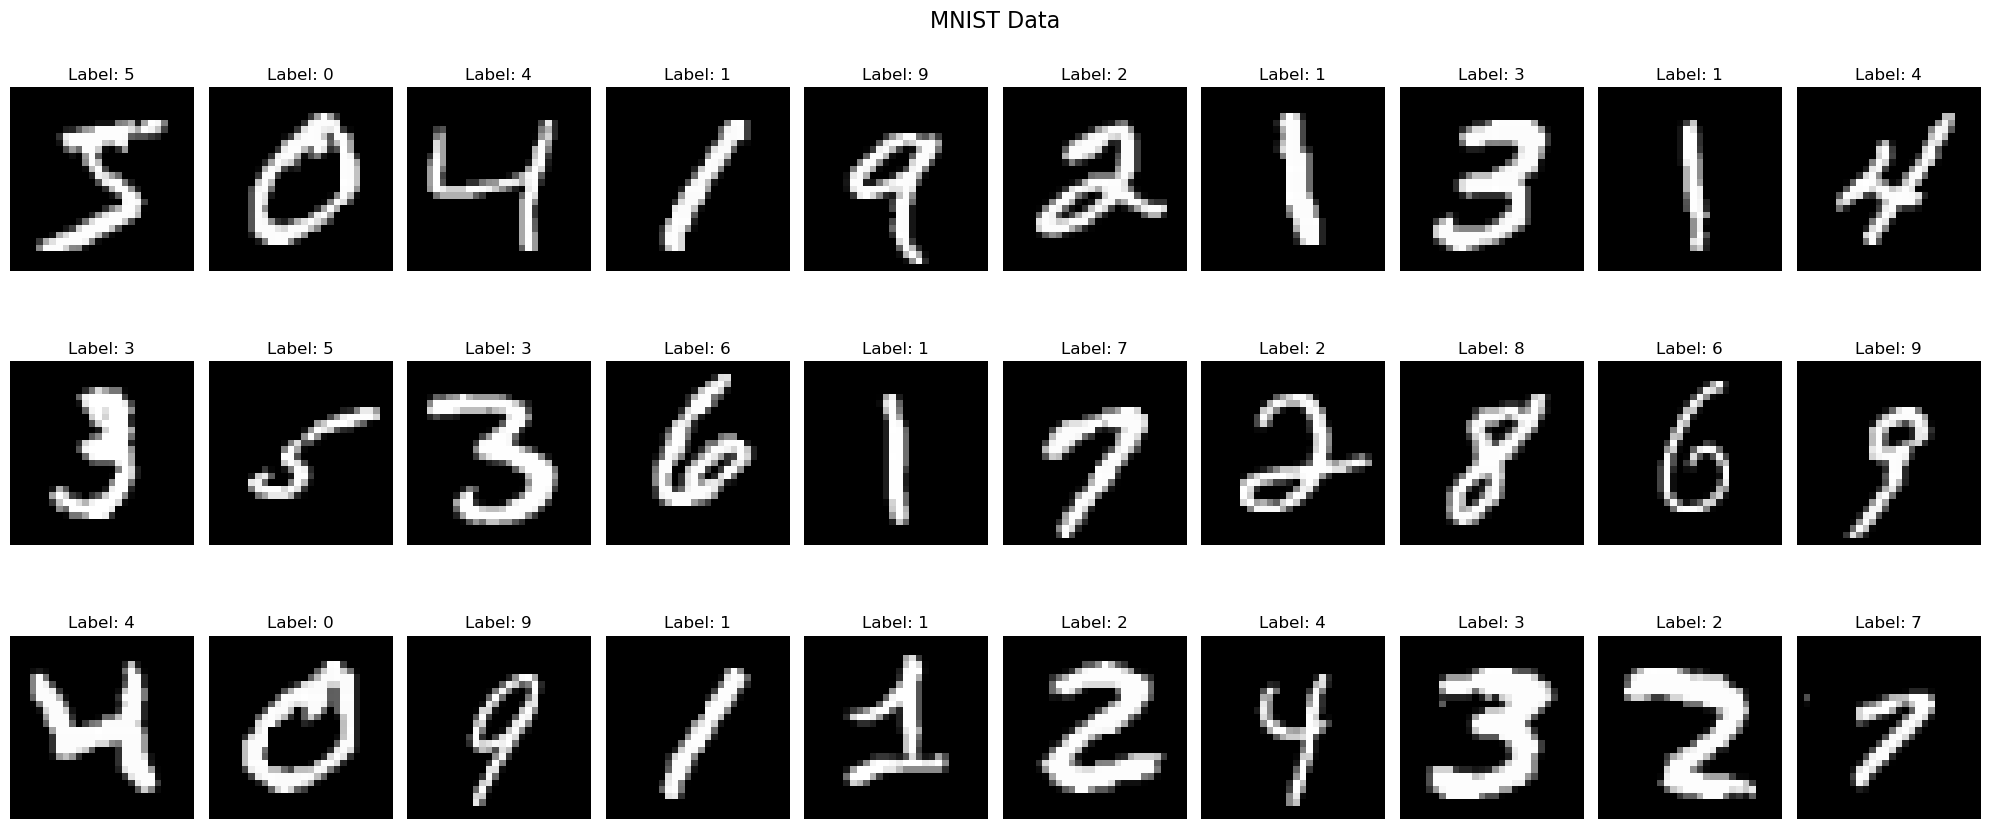

In [11]:
# Displaying some images from training data
display_images(x_train, y_train, 30, main_title='MNIST Data')

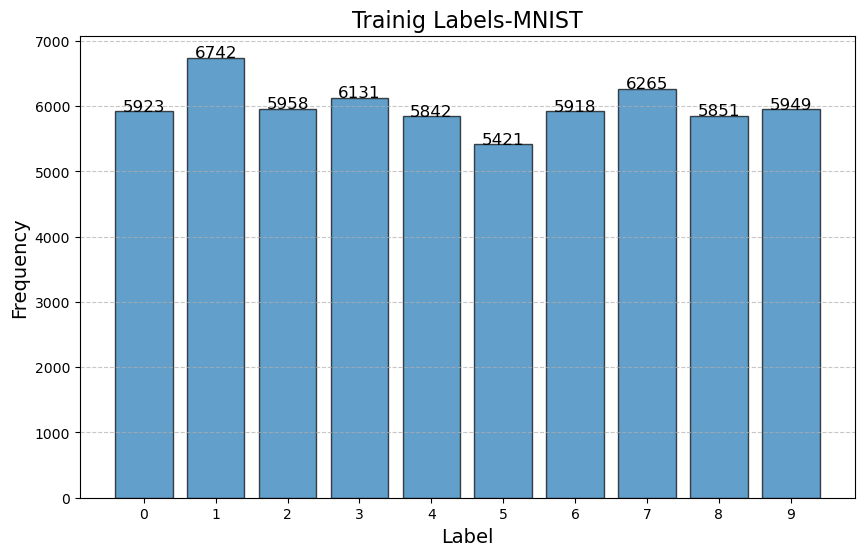

In [12]:
# Bar chart of the training labels 
plot_label_distribution(y_train, 'Trainig Labels-MNIST')

In [13]:
# Splitting training data into training and validation with validation making up 20% of the data 
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

In [14]:
print(f"The number of images in training set: {len(x_train)}")
print(f"The number of images in validation set: {len(x_val)}")
print(f"The number of images in test set: {len(y_test)}")

The number of images in training set: 48000
The number of images in validation set: 12000
The number of images in test set: 10000


# $\text{Illustration of stacking images vertically}$

In [13]:
# Selecting first two 28x28 images from the training set
image1 = x_train[0]  # First image
image2 = x_train[1]  # Second image

# Combining the two images vertically
combined_image_array = np.vstack((image1, image2))

# Converting the combined array to a PIL image for display
combined_image = Image.fromarray(combined_image_array)


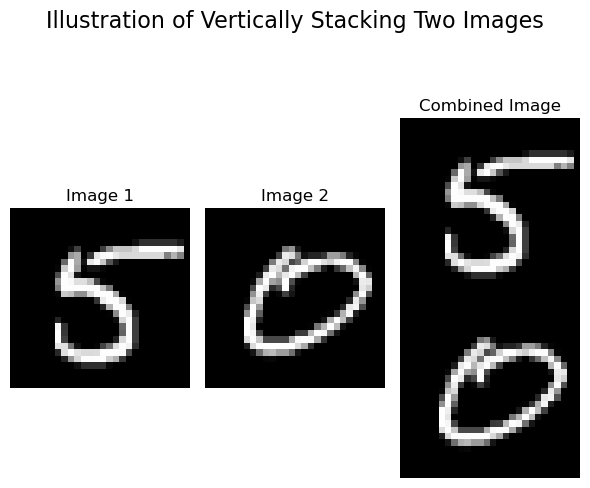

In [14]:
plt.figure(figsize=(6, 6))

# Image 1
plt.subplot(1, 3, 1)
plt.title("Image 1")
plt.imshow(image1, cmap='gray')
plt.axis('off')

# Image 2
plt.subplot(1, 3, 2)
plt.title("Image 2")
plt.imshow(image2, cmap='gray')
plt.axis('off')

# Combined Image
plt.subplot(1, 3, 3)
plt.title("Combined Image")
plt.imshow(combined_image_array, cmap='gray')
plt.axis('off')
plt.suptitle("Illustration of Vertically Stacking Two Images", fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# $\text{Pairing images and assigning labels}$ 

In [ ]:
# Vertically stacking images
paired_images_train, paired_labels_train, image_1_train, image_2_train, label_1_train, label_2_train  = generate_paired_data(x_train, y_train,43)
paired_images_val, paired_labels_val, image_1_val, images_2_val, label_1_val, label_2_val             = generate_paired_data(x_val, y_val, 43)
paired_images_test, paired_labels_test, image_1_test, image_2_test, label_1_test, label_2_test        = generate_paired_data(x_test, y_test, 43)

# Printing the shape 
print("Paired images train shape:", paired_images_train.shape)
print("Paired labels train shape:", paired_labels_train.shape)
print("Paired images val shape:", paired_images_val.shape)
print("Paired labels val shape:", paired_labels_val.shape)
print("Paired images test shape:", paired_images_test.shape)
print("Paired labels test shape:", paired_labels_test.shape)

Paired images train shape: (48000, 56, 28)
Paired labels train shape: (48000,)
Paired images val shape: (12000, 56, 28)
Paired labels val shape: (12000,)
Paired images test shape: (10000, 56, 28)
Paired labels test shape: (10000,)


In [17]:
# Printing the shape of individual image arrays
print("Upper images train shape:", image_1_train.shape)
print("Lower images train shape:", image_2_train.shape)

Upper images train shape: (48000, 28, 28)
Lower images train shape: (48000, 28, 28)


In [18]:
# Converting labels to one-hot encoded vectors for training, validation, and testing 
paired_labels_train_encode = to_categorical(paired_labels_train, 19)
paired_labels_val_encode   = to_categorical(paired_labels_val, 19)
paired_labels_test_encode  = to_categorical(paired_labels_test, 19)

In [19]:
# Printing the number of unique classes in training labels 
print(f"The number of classes is: {len(np.unique(paired_labels_train))}")

The number of classes is: 19


In [20]:
# Displaying the original and one-hot encoded labels for a few samples from training, validation, and test sets
print(paired_labels_train[1])
print(paired_labels_train_encode[1])
print('\n')
print(paired_labels_val[10])
print(paired_labels_val_encode[10])
print('\n')
print(paired_labels_test[5])
print(paired_labels_test_encode[5])

3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


11
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


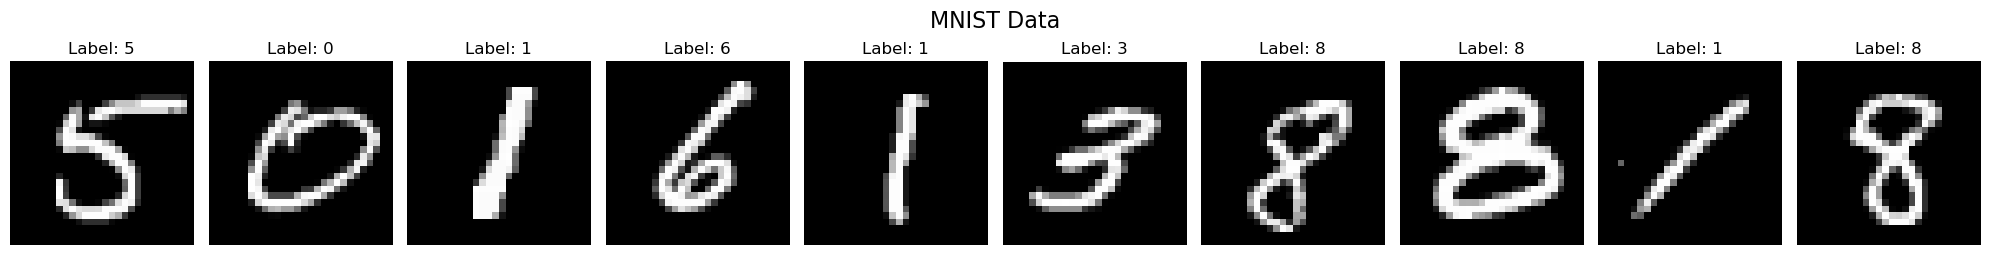

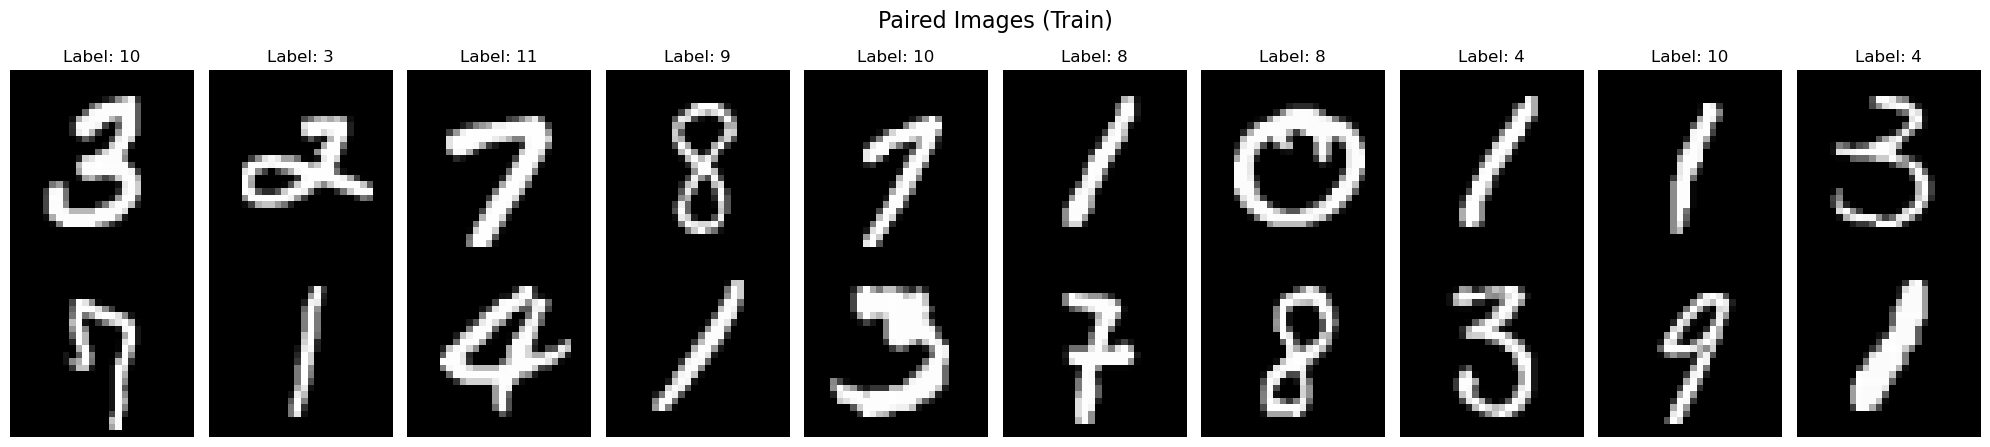

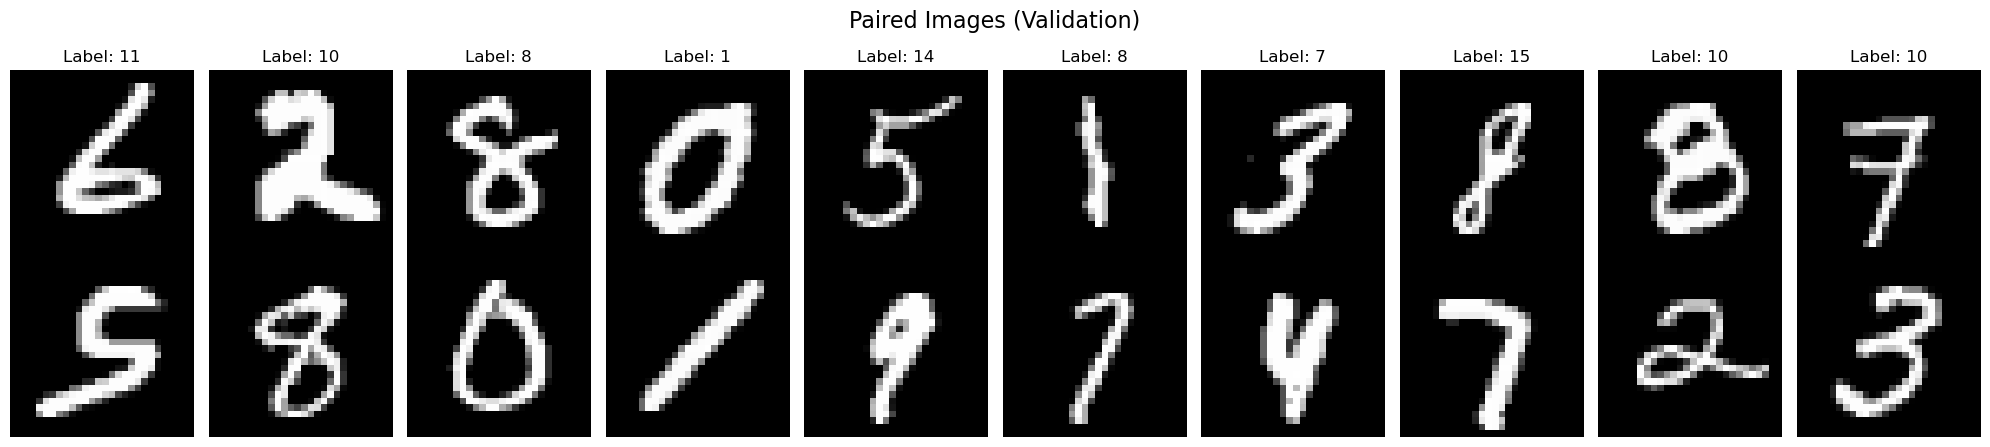

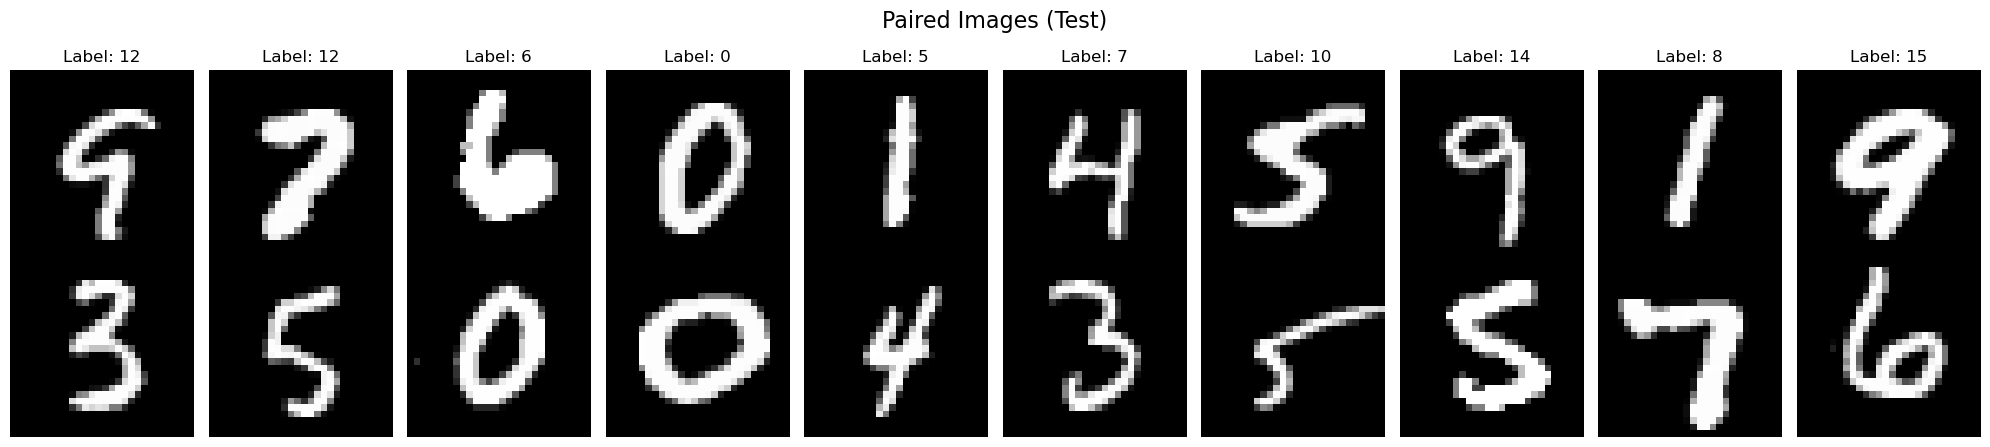

In [22]:
# Displaying some images from all sets
display_images(x_train, y_train, 10, main_title='MNIST Data', y=0.6)
display_images(paired_images_train, paired_labels_train, 10, main_title='Paired Images (Train)', y=0.7)
display_images(paired_images_val, paired_labels_val, 10, main_title='Paired Images (Validation)', y=0.7)
display_images(paired_images_test, paired_labels_test, 10, main_title='Paired Images (Test)', y=0.7)

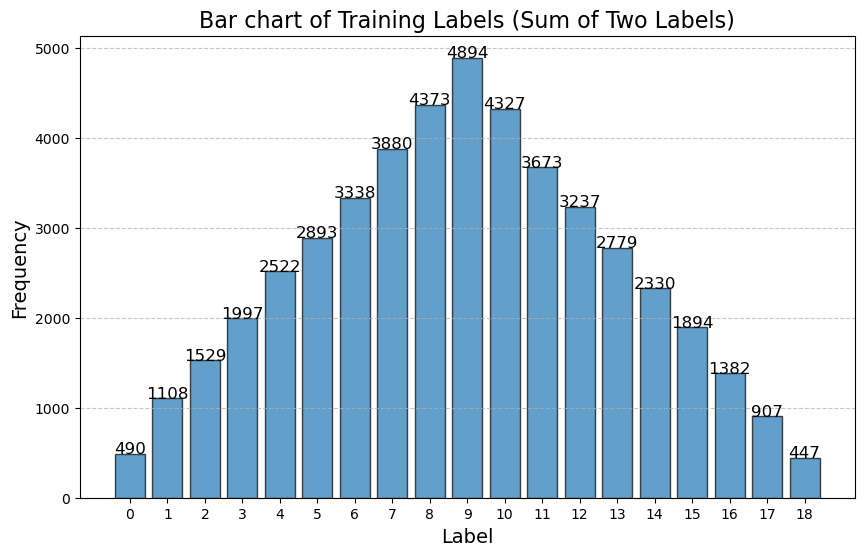

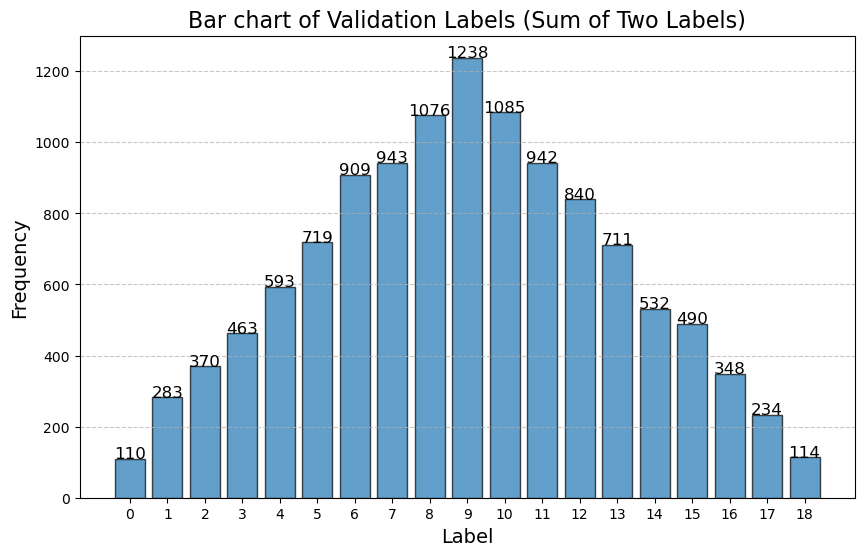

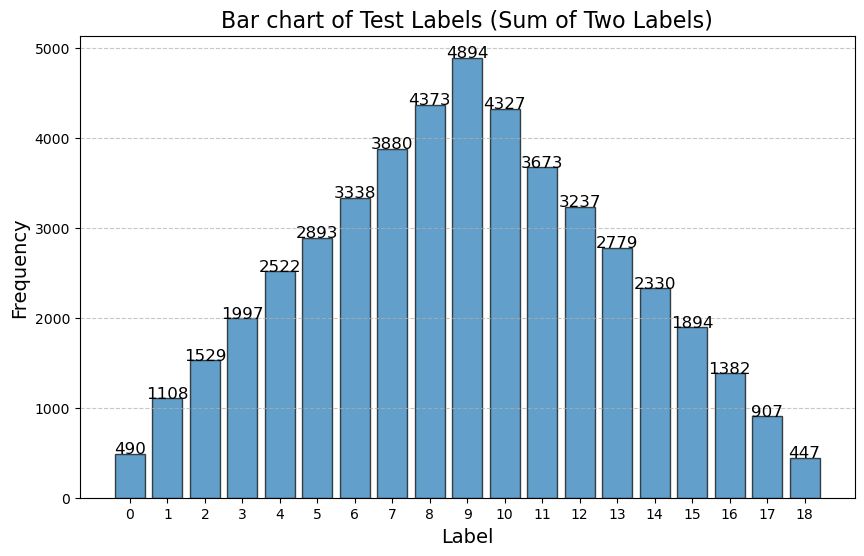

In [23]:
# Bar chart of the training labels (sum of two labels) 
plot_label_distribution(paired_labels_train, 'Bar chart of Training Labels (Sum of Two Labels)')
# Bar chart of the validation labels (sum of two labels) 
plot_label_distribution(paired_labels_val, 'Bar chart of Validation Labels (Sum of Two Labels)')
# Bar chart of the test labels (sum of two labels) 
plot_label_distribution(paired_labels_train, 'Bar chart of Test Labels (Sum of Two Labels)')

# $\text{Training a fully connected neural network}$ 

In [21]:
# Converts the data type of the arrays to float32
paired_images_train_32 = paired_images_train.astype('float32')
paired_images_val_32   = paired_images_val.astype('float32')
paired_images_test_32  = paired_images_test.astype('float32')

In [22]:
# Checking the data type of paired_images_train
print(paired_images_test_32.dtype)

float32


## $\text{Searching for the most optimal hyperparamters with Optuna}$

### $\text{Study 1}$ 

In [95]:
# Optuna objective function
def objective1(trial):
    # Suggesting hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 3)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    units = [trial.suggest_int(f'units_layer_{i}', 50, 400) for i in range(num_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    
    # Building the model
    model = Sequential()
    model.add(Flatten(input_shape=(56, 28)))
    
    for i in range(num_layers):
        model.add(Dense(units=units[i], activation=activation))
        model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(19, activation='softmax'))
    
    # Compiling the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Training the model
    history = model.fit(paired_images_train_32, paired_labels_train_encode, 
                        validation_split=0.2,
                        epochs=50, 
                        batch_size=128, 
                        verbose=0,
                        validation_data=(paired_images_val_32, paired_labels_val_encode))
    
    # Getting accuracy values
    val_accuracy = history.history['val_accuracy'][-1]
    train_accuracy = history.history['accuracy'][-1]
    
    # Evaluating the model on test data
    score = model.evaluate(paired_images_test_32, paired_labels_test_encode, verbose=0)
    test_accuracy = score[1]

    print(f"Validation accuracy: {val_accuracy}")
    print(f"Training accuracy: {train_accuracy}")

    # Return test accuracy for Optuna optimization
    return test_accuracy  

In [96]:
# Creating an Optuna study and optimizing the objective function
# Setting random seeds for reproducibility of results 
np.random.seed(43)    
tf.random.set_seed(43)
random.seed(43)

study1 = optuna.create_study(study_name="study 1",direction='maximize', sampler=optuna.samplers.TPESampler(seed=43))
study1.optimize(objective1, n_trials=25)  
#49mins 

[I 2024-12-15 10:41:40,008] A new study created in memory with name: study 1
[I 2024-12-15 10:43:30,418] Trial 0 finished with value: 0.16990000009536743 and parameters: {'num_layers': 1, 'activation': 'relu', 'dropout_rate': 0.12029480998267439, 'units_layer_0': 164, 'learning_rate': 0.027324357812978085}. Best is trial 0 with value: 0.16990000009536743.


Validation accuracy: 0.17208333313465118
Training accuracy: 0.16577082872390747


[I 2024-12-15 10:46:59,164] Trial 1 finished with value: 0.8449000120162964 and parameters: {'num_layers': 2, 'activation': 'relu', 'dropout_rate': 0.36687414814014147, 'units_layer_0': 188, 'units_layer_1': 331, 'learning_rate': 0.00010415605048648955}. Best is trial 1 with value: 0.8449000120162964.


Validation accuracy: 0.8393333554267883
Training accuracy: 0.8252291679382324


[I 2024-12-15 10:48:28,253] Trial 2 finished with value: 0.6207000017166138 and parameters: {'num_layers': 1, 'activation': 'relu', 'dropout_rate': 0.20249472402362984, 'units_layer_0': 160, 'learning_rate': 2.0260529906733127e-05}. Best is trial 1 with value: 0.8449000120162964.


Validation accuracy: 0.6106666922569275
Training accuracy: 0.5729791522026062


[I 2024-12-15 10:52:17,981] Trial 3 finished with value: 0.24940000474452972 and parameters: {'num_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.19268845719756905, 'units_layer_0': 385, 'units_layer_1': 206, 'units_layer_2': 285, 'learning_rate': 2.1379630681069628e-05}. Best is trial 1 with value: 0.8449000120162964.


Validation accuracy: 0.24391666054725647
Training accuracy: 0.2176041603088379


[I 2024-12-15 10:54:33,993] Trial 4 finished with value: 0.09690000116825104 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.0025647745322284754, 'units_layer_0': 240, 'units_layer_1': 216, 'units_layer_2': 273, 'learning_rate': 0.08181191083032673}. Best is trial 1 with value: 0.8449000120162964.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09812500327825546


[I 2024-12-15 10:56:33,902] Trial 5 finished with value: 0.09690000116825104 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.05200947492738145, 'units_layer_0': 113, 'units_layer_1': 384, 'units_layer_2': 194, 'learning_rate': 0.02884486312162627}. Best is trial 1 with value: 0.8449000120162964.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.10006249696016312


[I 2024-12-15 10:58:26,322] Trial 6 finished with value: 0.13729999959468842 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.4483736348704313, 'units_layer_0': 122, 'units_layer_1': 191, 'units_layer_2': 398, 'learning_rate': 0.00876815717103087}. Best is trial 1 with value: 0.8449000120162964.


Validation accuracy: 0.14100000262260437
Training accuracy: 0.13091666996479034


[I 2024-12-15 11:00:03,531] Trial 7 finished with value: 0.7748000025749207 and parameters: {'num_layers': 2, 'activation': 'relu', 'dropout_rate': 0.36349399598399423, 'units_layer_0': 190, 'units_layer_1': 285, 'learning_rate': 0.006589651263273639}. Best is trial 1 with value: 0.8449000120162964.


Validation accuracy: 0.7615833282470703
Training accuracy: 0.6273333430290222


[I 2024-12-15 11:01:44,562] Trial 8 finished with value: 0.9009000062942505 and parameters: {'num_layers': 2, 'activation': 'relu', 'dropout_rate': 0.09958073831135095, 'units_layer_0': 329, 'units_layer_1': 151, 'learning_rate': 0.004205826095392451}. Best is trial 8 with value: 0.9009000062942505.


Validation accuracy: 0.8946666717529297
Training accuracy: 0.9580833315849304


[I 2024-12-15 11:02:42,594] Trial 9 finished with value: 0.7771000266075134 and parameters: {'num_layers': 1, 'activation': 'sigmoid', 'dropout_rate': 0.15513476342229487, 'units_layer_0': 135, 'learning_rate': 0.0022512108365211883}. Best is trial 8 with value: 0.9009000062942505.


Validation accuracy: 0.7645833492279053
Training accuracy: 0.9075416922569275


[I 2024-12-15 11:04:18,511] Trial 10 finished with value: 0.8361999988555908 and parameters: {'num_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.29042530561962954, 'units_layer_0': 334, 'units_layer_1': 58, 'learning_rate': 0.00038757533491945087}. Best is trial 8 with value: 0.9009000062942505.


Validation accuracy: 0.8307499885559082
Training accuracy: 0.8095625042915344


[I 2024-12-15 11:05:49,523] Trial 11 finished with value: 0.8604000210762024 and parameters: {'num_layers': 2, 'activation': 'relu', 'dropout_rate': 0.3150721706009555, 'units_layer_0': 254, 'units_layer_1': 108, 'learning_rate': 0.00023599505485615049}. Best is trial 8 with value: 0.9009000062942505.


Validation accuracy: 0.8519166707992554
Training accuracy: 0.8891875147819519


[I 2024-12-15 11:07:20,334] Trial 12 finished with value: 0.8841999769210815 and parameters: {'num_layers': 2, 'activation': 'relu', 'dropout_rate': 0.2877182189332613, 'units_layer_0': 279, 'units_layer_1': 95, 'learning_rate': 0.000649035533229796}. Best is trial 8 with value: 0.9009000062942505.


Validation accuracy: 0.8827499747276306
Training accuracy: 0.9411041736602783


[I 2024-12-15 11:09:14,050] Trial 13 finished with value: 0.9106000065803528 and parameters: {'num_layers': 2, 'activation': 'relu', 'dropout_rate': 0.09889746190197557, 'units_layer_0': 300, 'units_layer_1': 135, 'learning_rate': 0.001371908629661375}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.9050833582878113
Training accuracy: 0.9859374761581421


[I 2024-12-15 11:11:05,748] Trial 14 finished with value: 0.8504999876022339 and parameters: {'num_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.06873911053455711, 'units_layer_0': 326, 'units_layer_1': 150, 'learning_rate': 0.0021857645260083603}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.8452500104904175
Training accuracy: 0.9872708320617676


[I 2024-12-15 11:13:00,696] Trial 15 finished with value: 0.8180000185966492 and parameters: {'num_layers': 1, 'activation': 'relu', 'dropout_rate': 0.10442626170300473, 'units_layer_0': 399, 'learning_rate': 0.0021765490063306156}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.8029999732971191
Training accuracy: 0.9751458168029785


[I 2024-12-15 11:14:20,190] Trial 16 finished with value: 0.7760000228881836 and parameters: {'num_layers': 2, 'activation': 'relu', 'dropout_rate': 0.21803121732372943, 'units_layer_0': 58, 'units_layer_1': 159, 'learning_rate': 8.514269440897656e-05}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.7667499780654907
Training accuracy: 0.687624990940094


[I 2024-12-15 11:16:35,877] Trial 17 finished with value: 0.8919000029563904 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.033292613984961056, 'units_layer_0': 334, 'units_layer_1': 272, 'units_layer_2': 54, 'learning_rate': 0.006581611314599364}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.8834166526794434
Training accuracy: 0.9505416750907898


[I 2024-12-15 11:18:11,341] Trial 18 finished with value: 0.8069999814033508 and parameters: {'num_layers': 1, 'activation': 'sigmoid', 'dropout_rate': 0.1411267658243468, 'units_layer_0': 296, 'learning_rate': 0.0011091442870403735}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.796916663646698
Training accuracy: 0.9656041860580444


[I 2024-12-15 11:20:26,177] Trial 19 finished with value: 0.7472000122070312 and parameters: {'num_layers': 2, 'activation': 'relu', 'dropout_rate': 0.08962942048763597, 'units_layer_0': 361, 'units_layer_1': 128, 'learning_rate': 0.01734827628083204}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.7400833368301392
Training accuracy: 0.6973124742507935


[I 2024-12-15 11:22:12,845] Trial 20 finished with value: 0.09690000116825104 and parameters: {'num_layers': 2, 'activation': 'relu', 'dropout_rate': 0.16650121566433546, 'units_layer_0': 287, 'units_layer_1': 81, 'learning_rate': 0.0779458630095391}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09806250035762787


[I 2024-12-15 11:24:22,881] Trial 21 finished with value: 0.8934999704360962 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.027345803566361127, 'units_layer_0': 329, 'units_layer_1': 268, 'units_layer_2': 53, 'learning_rate': 0.005514298024194839}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.8811666369438171
Training accuracy: 0.9632499814033508


[I 2024-12-15 11:26:31,727] Trial 22 finished with value: 0.904699981212616 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.0013281834525527003, 'units_layer_0': 311, 'units_layer_1': 249, 'units_layer_2': 52, 'learning_rate': 0.003310937546601833}. Best is trial 13 with value: 0.9106000065803528.


Validation accuracy: 0.8990833163261414
Training accuracy: 0.9897500276565552


[I 2024-12-15 11:28:54,678] Trial 23 finished with value: 0.9203000068664551 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.07659642730736792, 'units_layer_0': 364, 'units_layer_1': 162, 'units_layer_2': 153, 'learning_rate': 0.001068249253884062}. Best is trial 23 with value: 0.9203000068664551.


Validation accuracy: 0.9097499847412109
Training accuracy: 0.9891666769981384


[I 2024-12-15 11:30:55,888] Trial 24 finished with value: 0.9088000059127808 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.00226858779472557, 'units_layer_0': 272, 'units_layer_1': 244, 'units_layer_2': 160, 'learning_rate': 0.0008875055957368122}. Best is trial 23 with value: 0.9203000068664551.


Validation accuracy: 0.9004999995231628
Training accuracy: 0.9931458234786987


In [100]:
# Print the best trial
print('Best trial:')
print(f' Value: {study1.best_trial.value}')
print(' Params: ')
for key, value in study1.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.9203000068664551
 Params: 
    num_layers: 3
    activation: relu
    dropout_rate: 0.07659642730736792
    units_layer_0: 364
    units_layer_1: 162
    units_layer_2: 153
    learning_rate: 0.001068249253884062


### $\text{Study 2}$

In [106]:
def objective2(trial):
    # Suggestting hyperparameters
    num_layers = trial.suggest_int('num_layers', 3, 6)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.5, 0.9)
    units = [trial.suggest_int(f'units_layer_{i}', 400, 600) for i in range(num_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-1, 3e-1, log=True)
    
    # Building the model
    model = Sequential()
    model.add(Flatten(input_shape=(56, 28)))
    
    for i in range(num_layers):
        model.add(Dense(units=units[i], activation=activation))
        model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(19, activation='softmax'))
    
    # Compiling the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Training the model
    history = model.fit(paired_images_train_32, paired_labels_train_encode, 
                        validation_split=0.2,
                        epochs=50, 
                        batch_size=128, 
                        verbose=0,
                        validation_data=(paired_images_val_32, paired_labels_val_encode))
    
    # Getting accuracy values
    val_accuracy = history.history['val_accuracy'][-1]
    train_accuracy = history.history['accuracy'][-1]
    
    
    # Evaluating the model on test data
    score = model.evaluate(paired_images_test_32, paired_labels_test_encode, verbose=0)
    test_accuracy = score[1]

    print(f"Validation accuracy: {val_accuracy}")
    print(f"Training accuracy: {train_accuracy}")
    
    # Return test accuracy for Optuna optimization
    return  test_accuracy

In [108]:
# Creating an Optuna study and optimizing the objective function
# Setting random seeds for reproducibility of results 
np.random.seed(47)    
tf.random.set_seed(47)
random.seed(47)

study2 = optuna.create_study(direction='maximize', study_name='study 2',sampler=optuna.samplers.TPESampler(seed=43), load_if_exists=False)
study2.optimize(objective2, n_trials=25)
#138mins

[I 2024-12-15 12:44:08,805] A new study created in memory with name: study 2
[I 2024-12-15 12:50:20,338] Trial 0 finished with value: 0.09369999915361404 and parameters: {'num_layers': 6, 'activation': 'sigmoid', 'dropout_rate': 0.5240601112780945, 'units_layer_0': 485, 'units_layer_1': 509, 'units_layer_2': 577, 'units_layer_3': 533, 'units_layer_4': 431, 'units_layer_5': 491, 'learning_rate': 0.1193350931965927}. Best is trial 0 with value: 0.09369999915361404.


Validation accuracy: 0.08966666460037231
Training accuracy: 0.06802083551883698


[I 2024-12-15 12:55:04,670] Trial 1 finished with value: 0.07909999787807465 and parameters: {'num_layers': 4, 'activation': 'sigmoid', 'dropout_rate': 0.5713630778811544, 'units_layer_0': 503, 'units_layer_1': 477, 'units_layer_2': 503, 'units_layer_3': 473, 'learning_rate': 0.20631312553270634}. Best is trial 0 with value: 0.09369999915361404.


Validation accuracy: 0.07858332991600037
Training accuracy: 0.06849999725818634


[I 2024-12-15 13:01:09,662] Trial 2 finished with value: 0.07909999787807465 and parameters: {'num_layers': 6, 'activation': 'sigmoid', 'dropout_rate': 0.8331012282712073, 'units_layer_0': 539, 'units_layer_1': 543, 'units_layer_2': 442, 'units_layer_3': 448, 'units_layer_4': 530, 'units_layer_5': 536, 'learning_rate': 0.14468161921557549}. Best is trial 0 with value: 0.09369999915361404.


Validation accuracy: 0.07858332991600037
Training accuracy: 0.07318750023841858


[I 2024-12-15 13:06:08,288] Trial 3 finished with value: 0.09690000116825104 and parameters: {'num_layers': 5, 'activation': 'relu', 'dropout_rate': 0.6324646320048426, 'units_layer_0': 439, 'units_layer_1': 470, 'units_layer_2': 469, 'units_layer_3': 413, 'units_layer_4': 564, 'learning_rate': 0.16250452489515918}. Best is trial 3 with value: 0.09690000116825104.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.0963541641831398


[I 2024-12-15 13:09:45,884] Trial 4 finished with value: 0.07240000367164612 and parameters: {'num_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.6078898153997732, 'units_layer_0': 518, 'units_layer_1': 473, 'units_layer_2': 448, 'learning_rate': 0.16688713143087017}. Best is trial 3 with value: 0.09690000116825104.


Validation accuracy: 0.07575000077486038
Training accuracy: 0.06808333098888397


[I 2024-12-15 13:13:37,659] Trial 5 finished with value: 0.09690000116825104 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.675925405333348, 'units_layer_0': 492, 'units_layer_1': 538, 'units_layer_2': 452, 'learning_rate': 0.10937519100600969}. Best is trial 3 with value: 0.09690000116825104.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09577083587646484


[I 2024-12-15 13:19:55,037] Trial 6 finished with value: 0.09690000116825104 and parameters: {'num_layers': 5, 'activation': 'sigmoid', 'dropout_rate': 0.7188537287091703, 'units_layer_0': 582, 'units_layer_1': 461, 'units_layer_2': 588, 'units_layer_3': 535, 'units_layer_4': 513, 'learning_rate': 0.1004036875173864}. Best is trial 3 with value: 0.09690000116825104.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.06743749976158142


[I 2024-12-15 13:25:25,762] Trial 7 finished with value: 0.09679999947547913 and parameters: {'num_layers': 4, 'activation': 'sigmoid', 'dropout_rate': 0.6125406780087108, 'units_layer_0': 417, 'units_layer_1': 447, 'units_layer_2': 455, 'units_layer_3': 558, 'learning_rate': 0.20494945783004756}. Best is trial 3 with value: 0.09690000116825104.


Validation accuracy: 0.09041666984558105
Training accuracy: 0.0677291676402092


[I 2024-12-15 13:33:55,848] Trial 8 finished with value: 0.09690000116825104 and parameters: {'num_layers': 5, 'activation': 'relu', 'dropout_rate': 0.8256735419677279, 'units_layer_0': 484, 'units_layer_1': 465, 'units_layer_2': 443, 'units_layer_3': 438, 'units_layer_4': 473, 'learning_rate': 0.11250370817299377}. Best is trial 3 with value: 0.09690000116825104.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09585416316986084


[I 2024-12-15 13:40:52,117] Trial 9 finished with value: 0.09690000116825104 and parameters: {'num_layers': 6, 'activation': 'sigmoid', 'dropout_rate': 0.893092204517256, 'units_layer_0': 547, 'units_layer_1': 402, 'units_layer_2': 489, 'units_layer_3': 400, 'units_layer_4': 577, 'units_layer_5': 466, 'learning_rate': 0.11280604013963574}. Best is trial 3 with value: 0.09690000116825104.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09231249988079071


[I 2024-12-15 13:48:47,796] Trial 10 finished with value: 0.09690000116825104 and parameters: {'num_layers': 5, 'activation': 'relu', 'dropout_rate': 0.7155088073517267, 'units_layer_0': 414, 'units_layer_1': 593, 'units_layer_2': 400, 'units_layer_3': 599, 'units_layer_4': 593, 'learning_rate': 0.2862820345756973}. Best is trial 3 with value: 0.09690000116825104.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09462500363588333


[I 2024-12-15 13:54:02,537] Trial 11 finished with value: 0.09700000286102295 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.6654426182610178, 'units_layer_0': 452, 'units_layer_1': 538, 'units_layer_2': 495, 'learning_rate': 0.1432705224404544}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.0964374989271164


[I 2024-12-15 14:00:06,309] Trial 12 finished with value: 0.09690000116825104 and parameters: {'num_layers': 4, 'activation': 'relu', 'dropout_rate': 0.6586968169712764, 'units_layer_0': 444, 'units_layer_1': 573, 'units_layer_2': 522, 'units_layer_3': 407, 'learning_rate': 0.14837073125946995}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09656249731779099


[I 2024-12-15 14:04:37,319] Trial 13 finished with value: 0.09690000116825104 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.7522641364732907, 'units_layer_0': 451, 'units_layer_1': 505, 'units_layer_2': 542, 'learning_rate': 0.19021589509331296}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.0964166671037674


[I 2024-12-15 14:09:42,907] Trial 14 finished with value: 0.09690000116825104 and parameters: {'num_layers': 4, 'activation': 'relu', 'dropout_rate': 0.5099802679250947, 'units_layer_0': 451, 'units_layer_1': 429, 'units_layer_2': 483, 'units_layer_3': 489, 'learning_rate': 0.24583975345871234}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09533333033323288


[I 2024-12-15 14:16:00,488] Trial 15 finished with value: 0.09690000116825104 and parameters: {'num_layers': 5, 'activation': 'relu', 'dropout_rate': 0.647177642912868, 'units_layer_0': 436, 'units_layer_1': 533, 'units_layer_2': 552, 'units_layer_3': 443, 'units_layer_4': 548, 'learning_rate': 0.13809981988052603}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09593749791383743


[I 2024-12-15 14:21:00,213] Trial 16 finished with value: 0.09690000116825104 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.574320610264468, 'units_layer_0': 465, 'units_layer_1': 561, 'units_layer_2': 475, 'learning_rate': 0.16590578195998726}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.0964374989271164


[I 2024-12-15 14:26:39,015] Trial 17 finished with value: 0.09690000116825104 and parameters: {'num_layers': 4, 'activation': 'relu', 'dropout_rate': 0.7673337403253684, 'units_layer_0': 422, 'units_layer_1': 493, 'units_layer_2': 412, 'units_layer_3': 511, 'learning_rate': 0.1321252728799537}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09591666609048843


[I 2024-12-15 14:33:41,577] Trial 18 finished with value: 0.09690000116825104 and parameters: {'num_layers': 5, 'activation': 'relu', 'dropout_rate': 0.6198501555079927, 'units_layer_0': 471, 'units_layer_1': 520, 'units_layer_2': 515, 'units_layer_3': 468, 'units_layer_4': 479, 'learning_rate': 0.15839825826790468}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09668750315904617


[I 2024-12-15 14:40:40,721] Trial 19 finished with value: 0.09690000116825104 and parameters: {'num_layers': 6, 'activation': 'relu', 'dropout_rate': 0.5593023787767084, 'units_layer_0': 409, 'units_layer_1': 422, 'units_layer_2': 471, 'units_layer_3': 424, 'units_layer_4': 410, 'units_layer_5': 405, 'learning_rate': 0.18619191314562092}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09591666609048843


[I 2024-12-15 14:45:19,346] Trial 20 finished with value: 0.09690000116825104 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.692674733447718, 'units_layer_0': 436, 'units_layer_1': 492, 'units_layer_2': 536, 'learning_rate': 0.12773180696727168}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09597916901111603


[I 2024-12-15 14:49:47,914] Trial 21 finished with value: 0.09690000116825104 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.6649130046482193, 'units_layer_0': 507, 'units_layer_1': 550, 'units_layer_2': 425, 'learning_rate': 0.10059480745125532}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09549999982118607


[I 2024-12-15 14:53:21,673] Trial 22 finished with value: 0.09690000116825104 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.6962142242565529, 'units_layer_0': 487, 'units_layer_1': 532, 'units_layer_2': 461, 'learning_rate': 0.12229261083069991}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.09647917002439499


[I 2024-12-15 14:58:20,153] Trial 23 finished with value: 0.09690000116825104 and parameters: {'num_layers': 4, 'activation': 'relu', 'dropout_rate': 0.7552936921238184, 'units_layer_0': 466, 'units_layer_1': 584, 'units_layer_2': 496, 'units_layer_3': 595, 'learning_rate': 0.1524189551771264}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10316666960716248
Training accuracy: 0.0963958352804184


[I 2024-12-15 15:02:30,936] Trial 24 finished with value: 0.09690000116825104 and parameters: {'num_layers': 3, 'activation': 'relu', 'dropout_rate': 0.6455110471059674, 'units_layer_0': 527, 'units_layer_1': 564, 'units_layer_2': 434, 'learning_rate': 0.18215165298111324}. Best is trial 11 with value: 0.09700000286102295.


Validation accuracy: 0.10308333486318588
Training accuracy: 0.0963958352804184


In [109]:
# Print the best trial
print('Best trial:')
print(f' Value: {study2.best_trial.value}')
print(' Params: ')
for key, value in study2.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.09700000286102295
 Params: 
    num_layers: 3
    activation: relu
    dropout_rate: 0.6654426182610178
    units_layer_0: 452
    units_layer_1: 538
    units_layer_2: 495
    learning_rate: 0.1432705224404544


### $\text{Model 1}$

In [24]:
# Setting deterministic environemnt for reproducibility 
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [30]:
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(43)
num_classes = 19
input_network = Input(shape=(56,28))              # Input layer: Vertically stacked images with shape 56*28
x = Flatten()(input_network)                      # Flattening the input images into a 1D vector so it can be fed into a dense layer
x = Dense(364, activation='relu')(x)              # Adding first hidden (dense) layer: 364 neurons and activation function `ReLU` 
x = Dropout(rate=0.07659642730736792)(x)          # Adding dropout layer: randomly sets some of the input units to 0 with a rate equal to 0.07659642730736792
x = Dense(162, activation='relu')(x)              # Adding second hidden layer: 162 neurons with activation function `ReLU`
x = Dropout(rate=0.07659642730736792)(x)          # Another dropout layer with the same rate 
x = Dense(153, activation='relu')(x)              # Third hidden layer: 153 neurons, using ReLU activation function
x = Dropout(rate=0.07659642730736792)(x)          # Another dropout layer with the same rate
y = Dense(num_classes, activation='softmax')(x)   # Output layer: Softmax activation function, which will output probabilities for each class in the range [0, 1]

model= Model(input_network,outputs=y)             # Defining the model by specifying the input and output layers
opt = Adam(learning_rate=0.0012689776092912246)   # Adam optimizer with a learning rate equal to 0.0012689776092912246
model.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy']) # Compile the model with categorical cross-entropy loss (for multi-class classification)
model.summary()                                   # Printing the model summary to check the architecture of the neural network

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 56, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 1568)              0         
                                                                 
 dense_8 (Dense)             (None, 364)               571116    
                                                                 
 dropout_6 (Dropout)         (None, 364)               0         
                                                                 
 dense_9 (Dense)             (None, 162)               59130     
                                                                 
 dropout_7 (Dropout)         (None, 162)               0         
                                                                 
 dense_10 (Dense)            (None, 153)               2493

In [ ]:
batch_size = 128
epochs=50
history1=model.fit(paired_images_train_32, paired_labels_train_encode,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(paired_images_val_32, paired_labels_val_encode))
#3mins

Epoch 1/50
375/375 [==============================] - 9s 12ms/step - loss: 1.6790 - accuracy: 0.4516 - val_loss: 0.8713 - val_accuracy: 0.7365
Epoch 2/50
375/375 [==============================] - 3s 8ms/step - loss: 0.7527 - accuracy: 0.7696 - val_loss: 0.5786 - val_accuracy: 0.8263
Epoch 3/50
375/375 [==============================] - 3s 8ms/step - loss: 0.5087 - accuracy: 0.8461 - val_loss: 0.4884 - val_accuracy: 0.8576
Epoch 4/50
375/375 [==============================] - 3s 8ms/step - loss: 0.3851 - accuracy: 0.8834 - val_loss: 0.4325 - val_accuracy: 0.8746
Epoch 5/50
375/375 [==============================] - 3s 8ms/step - loss: 0.3035 - accuracy: 0.9084 - val_loss: 0.4255 - val_accuracy: 0.8788
Epoch 6/50
375/375 [==============================] - 3s 9ms/step - loss: 0.2448 - accuracy: 0.9241 - val_loss: 0.3997 - val_accuracy: 0.8895
Epoch 7/50
375/375 [==============================] - 3s 7ms/step - loss: 0.1971 - accuracy: 0.9404 - val_loss: 0.4247 - val_accuracy: 0.8888
Epoch

In [32]:
test_loss_1, test_accuaracy_1 = evaluate_and_return_results(model, paired_images_val_32, paired_labels_val_encode, paired_images_test_32, paired_labels_test_encode)

train_loss_1 = history1.history['loss'][-1]
train_accuracy_1 = history1.history['accuracy'][-1]  # Get the last epoch's training accuracy
print(f"Training Accuracy: {train_accuracy_1:.4f}")  # Get the last epoch's training loss
print(f"Training Loss: {train_loss_1:.4f}")

375/375 [==============================] - 1s 3ms/step - loss: 0.5267 - accuracy: 0.9120
Validation Loss: 0.5267400145530701, Validation Accuracy: 0.9120000004768372
313/313 [==============================] - 1s 2ms/step - loss: 0.4741 - accuracy: 0.9208
Test Loss: 0.47413012385368347
Test Accuracy: 0.920799970626831
Training Accuracy: 0.9895
Training Loss: 0.0362


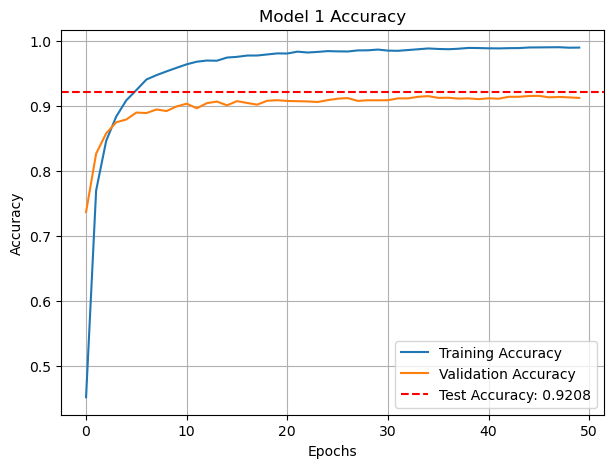

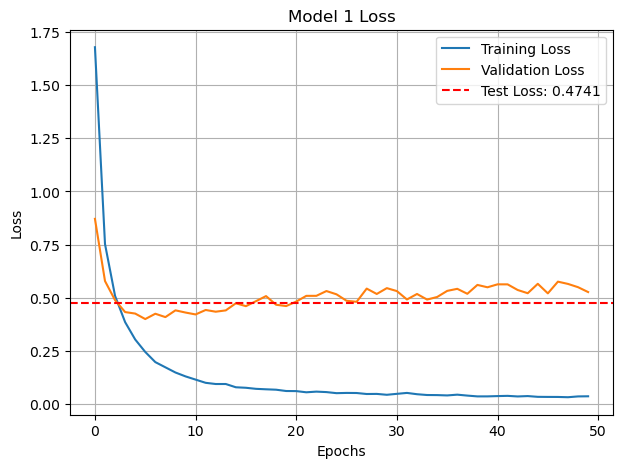

In [33]:
plot_training_results(history1, test_accuaracy_1, test_loss_1, 1)

In [31]:
predicted_classes, true_classes = evaluate_predictions(
    model,
    paired_images_test,
    paired_labels_test, 
    top_n=20
)

313/313 [==============================] - 1s 2ms/step
Predicted Classes: [12 12  6  0  5  7 10 14  8 15 10  7 16 12  8 12 10 16  7 11]
True Classes: [12 12  6  0  5  7 10 14  8 15 10  7 16 12  8 12 16 16  7 11]


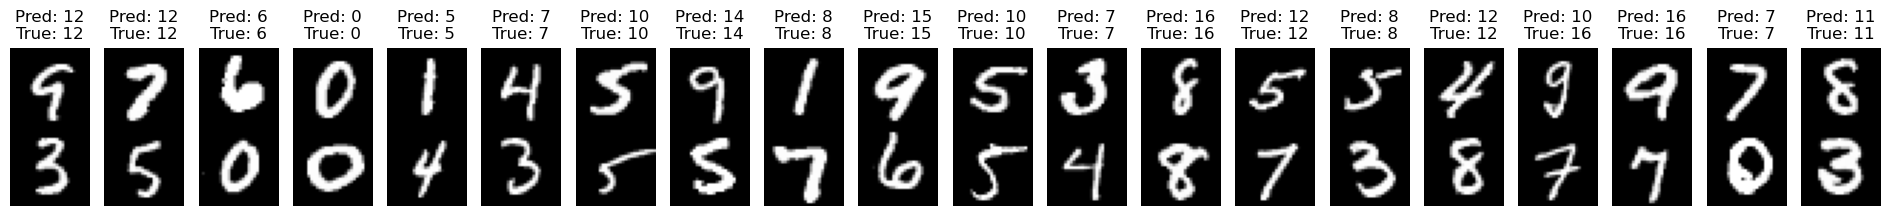

In [32]:
plot_predictions(
    paired_images_test_32,
    predicted_classes,
    true_classes,
    num_images=20
)

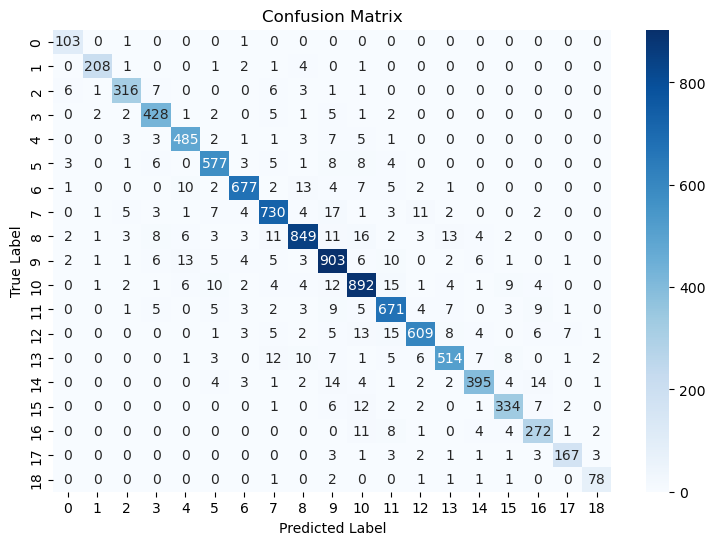

In [33]:
plot_confusion_matrix(true_classes, predicted_classes)

In [34]:
# # Saving model 2 (including its weights) and its training history 
# model.save('model1.h5')
# with open('training_history_model1.json', 'w') as file:
#     json.dump(history1.history, file)
# best_model_weights = model.save_weights("weights_model1.h5")

### $\text{Model 2}$

In [25]:
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(43)
num_classes = 19
input_network = Input(shape=(56,28))                # Input layer: Vertically stacked images with shape 56*28                         
x = Flatten()(input_network)                        # Flattening the input images into a 1D vector so it can be fed into a dense layer                                          
x = Dense(295, activation='relu')(x)                # Adding first hidden (dense) layer: 295 neurons and activation function `ReLU` 
x = Dropout(rate=0.3)(x)                            # Adding dropout layer: randomly sets some of the input units to 0 with a rate equal to 0.3
x = Dense(500, activation='relu')(x)                # Adding second hidden layer: 500 neurons with activation function `ReLU`
x = Dropout(rate=0.3)(x)                            # Another dropout layer with the same rate 
x = Dense(400, activation='relu')(x)                # Third hidden layer: 400 neurons, using ReLU activation function
x = Dropout(rate=0.3)(x)                            # Another dropout layer with the same rate
y = Dense(num_classes, activation='softmax')(x)     # Output layer: Softmax activation function, which will output probabilities for each class in the range [0, 1]

model2= Model(input_network,outputs=y)              # Defining the model by specifying the input and output layers
opt = Adam(learning_rate=0.001)                     # Adam optimizer with a learning rate equal to 0.001
model2.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])  # Compile the model with categorical cross-entropy loss (for multi-class classification)
model2.summary()                                    # Printing the model summary to check the architecture of the neural network 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 56, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_4 (Dense)             (None, 295)               462855    
                                                                 
 dropout_3 (Dropout)         (None, 295)               0         
                                                                 
 dense_5 (Dense)             (None, 500)               148000    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 400)               2004

In [26]:
batch_size = 128
epochs=50
history2=model2.fit(paired_images_train_32, paired_labels_train_encode,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(paired_images_val_32, paired_labels_val_encode))
#3mins

Epoch 1/50
375/375 [==============================] - 7s 15ms/step - loss: 1.9017 - accuracy: 0.3633 - val_loss: 1.0043 - val_accuracy: 0.6930
Epoch 2/50
375/375 [==============================] - 4s 12ms/step - loss: 1.0060 - accuracy: 0.6852 - val_loss: 0.6617 - val_accuracy: 0.8048
Epoch 3/50
375/375 [==============================] - 5s 12ms/step - loss: 0.7548 - accuracy: 0.7712 - val_loss: 0.5463 - val_accuracy: 0.8420
Epoch 4/50
375/375 [==============================] - 4s 12ms/step - loss: 0.6145 - accuracy: 0.8157 - val_loss: 0.4876 - val_accuracy: 0.8616
Epoch 5/50
375/375 [==============================] - 4s 10ms/step - loss: 0.5282 - accuracy: 0.8404 - val_loss: 0.4467 - val_accuracy: 0.8722
Epoch 6/50
375/375 [==============================] - 4s 10ms/step - loss: 0.4675 - accuracy: 0.8617 - val_loss: 0.4203 - val_accuracy: 0.8811
Epoch 7/50
375/375 [==============================] - 5s 12ms/step - loss: 0.4171 - accuracy: 0.8764 - val_loss: 0.4126 - val_accuracy: 0.8813

In [27]:
test_loss_2, test_accuracy_2 = evaluate_and_return_results(model2,paired_images_val_32, paired_labels_val_encode, paired_images_test_32, paired_labels_test_encode)

train_loss_2 = history2.history['loss'][-1]
train_accuracy_2 = history2.history['accuracy'][-1]  # Get the last epoch's training accuracy
print(f"Training Accuracy: {train_accuracy_2:.4f}")  # Get the last epoch's training loss
print(f"Training Loss: {train_loss_2:.4f}")

375/375 [==============================] - 2s 3ms/step - loss: 0.4075 - accuracy: 0.9154
Validation Loss: 0.4075002074241638, Validation Accuracy: 0.9154166579246521
313/313 [==============================] - 1s 3ms/step - loss: 0.3493 - accuracy: 0.9302
Test Loss: 0.34927213191986084
Test Accuracy: 0.9301999807357788
Training Accuracy: 0.9646
Training Loss: 0.1192


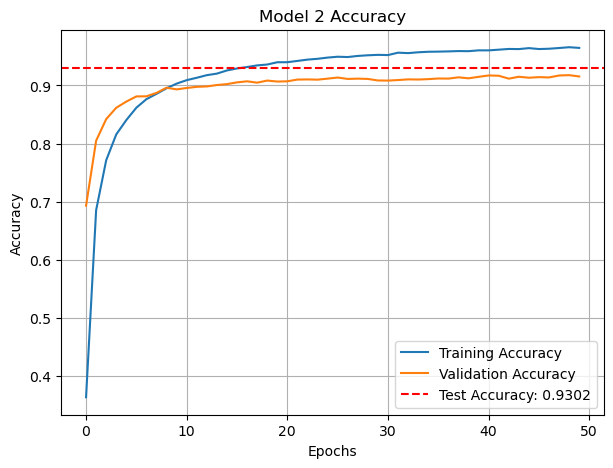

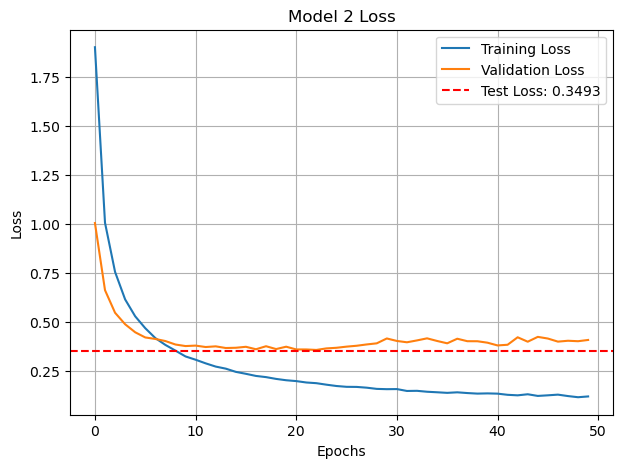

In [28]:
plot_training_results(history2, test_accuracy_2, test_loss_2, 2 )

In [197]:
predicted_classes_2, true_classes_2 = evaluate_predictions(
    model2,
    paired_images_test,
    paired_labels_test,  # Replace with paired_labels_test if not one-hot encoded
    top_n=20
)

313/313 [==============================] - 1s 3ms/step
Predicted Classes: [ 8 12  6  0  5  7 10 14  8 15 10  7 16 12  8 12 10 16  7 11]
True Classes: [12 12  6  0  5  7 10 14  8 15 10  7 16 12  8 12 16 16  7 11]


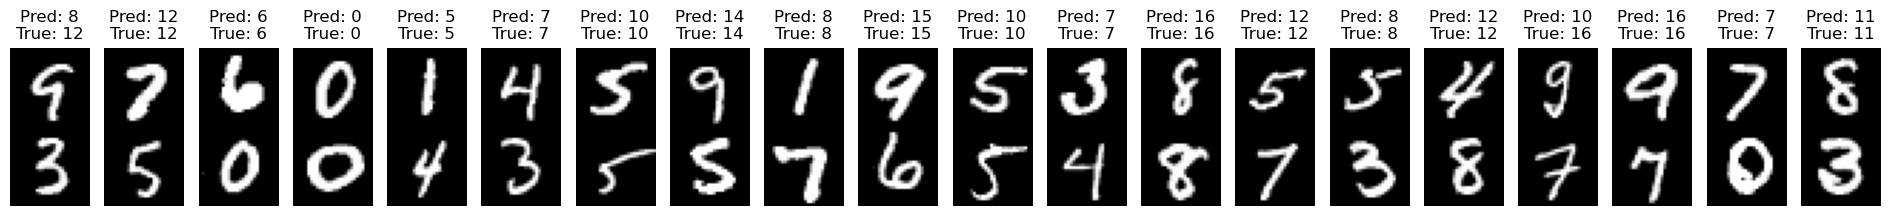

In [198]:
plot_predictions(
    paired_images_test_32,
    predicted_classes_2,
    true_classes,
    num_images=20
)

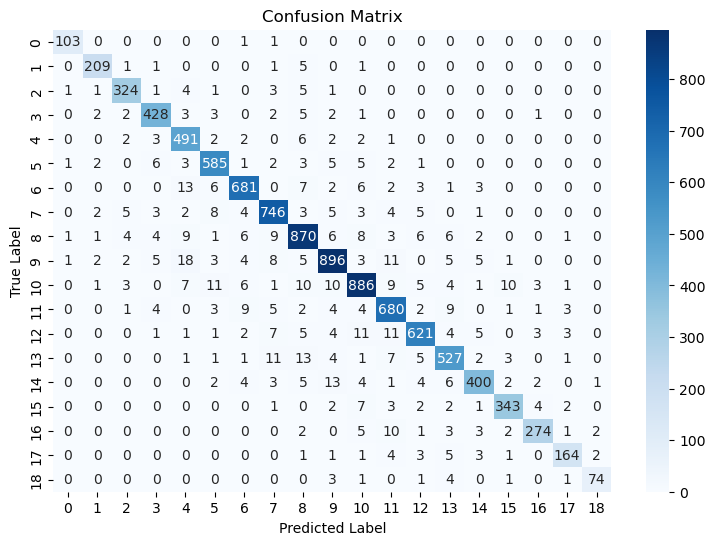

In [199]:
plot_confusion_matrix(true_classes_2, predicted_classes_2)

In [29]:
# # Saving model 2 (including its weights) and its training history 
# model2.save('model2.h5')
# with open('training_history_model2.json', 'w') as file:
#     json.dump(history2.history, file)
# best_model_weights = model2.save_weights("weights_model2.h5")

### $\text{Model 3: Batch Normalization}$

In [162]:
# adding batch normalization after the first hidden layer 
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(43)
num_classes = 19
input_network = Input(shape=(56,28))                 # Input layer: Vertically stacked images with shape 56*28
x = Flatten()(input_network)                         # Flattening the input images into a 1D vector so it can be fed into a dense layer
x = Dense(295, activation='relu')(x)                 # Adding first hidden (dense) layer: 295 neurons and activation function `ReLU` 
x = BatchNormalization()(x)                          # Batch normalization layer: normalizes the output of the previous layer
x = Dropout(rate=0.3)(x)                             # Adding dropout layer: randomly sets some of the input units to 0 with a rate equal to 0.3
x = Dense(500, activation='relu')(x)                 # Adding second hidden layer: 500 neurons with activation function `ReLU`
x = BatchNormalization()(x)                          # Another batch normalization layer
x = Dropout(rate=0.3)(x)                             # Another dropout layer with the same rate 
x = Dense(400, activation='relu')(x)                 # Third hidden layer: 400 neurons, using ReLU activation function
x = BatchNormalization()(x)                          # Third batch normalization layer
x = Dropout(rate=0.3)(x)                             # Another dropout layer with the same rate
y = Dense(num_classes, activation='softmax')(x)      # Output layer: Softmax activation function, which will output probabilities for each class in the range [0, 1]
 
model3= Model(input_network,outputs=y)               # Defining the model by specifying the input and output layers
opt = Adam(learning_rate=0.001)                      # Adam optimizer with a learning rate equal to 0.001
model3.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])  # Compile the model with categorical cross-entropy loss (for multi-class classification)
model3.summary()                                     # Printing the model summary to check the architecture of the neural network 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 295)               462855    
                                                                 
 batch_normalization (BatchN  (None, 295)              1180      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 295)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               148000    
                                                             

In [163]:
epochs=50
batch_size=128
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,               # Stop training after 10 epochs with no improvement
    restore_best_weights=True  # Restore the model's weights from the best epoch
)
history3=model3.fit(paired_images_train_32, paired_labels_train_encode,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(paired_images_val_32, paired_labels_val_encode), callbacks=[early_stopping])
#2mins to run

Epoch 1/50
375/375 [==============================] - 8s 13ms/step - loss: 2.0472 - accuracy: 0.3734 - val_loss: 0.9760 - val_accuracy: 0.6877
Epoch 2/50
375/375 [==============================] - 3s 8ms/step - loss: 1.0476 - accuracy: 0.6674 - val_loss: 0.6540 - val_accuracy: 0.8025
Epoch 3/50
375/375 [==============================] - 4s 12ms/step - loss: 0.7715 - accuracy: 0.7629 - val_loss: 0.5457 - val_accuracy: 0.8388
Epoch 4/50
375/375 [==============================] - 3s 9ms/step - loss: 0.6252 - accuracy: 0.8104 - val_loss: 0.4651 - val_accuracy: 0.8627
Epoch 5/50
375/375 [==============================] - 3s 8ms/step - loss: 0.5344 - accuracy: 0.8397 - val_loss: 0.4384 - val_accuracy: 0.8747
Epoch 6/50
375/375 [==============================] - 3s 8ms/step - loss: 0.4656 - accuracy: 0.8610 - val_loss: 0.4202 - val_accuracy: 0.8806
Epoch 7/50
375/375 [==============================] - 3s 8ms/step - loss: 0.4194 - accuracy: 0.8737 - val_loss: 0.4009 - val_accuracy: 0.8855
Epoc

In [164]:
test_loss_3, test_accuracy_3 = evaluate_and_return_results(model3, paired_images_val_32, paired_labels_val_encode, paired_images_test_32, paired_labels_test_encode)
train_accuracy_3 = history3.history['accuracy'][-1]
train_loss_3 = history3.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy_3:.4f}")
print(f"Training Loss: {train_loss_3:.4f}")


375/375 [==============================] - 1s 2ms/step - loss: 0.2986 - accuracy: 0.9283
Validation Loss: 0.2985890805721283, Validation Accuracy: 0.9283333420753479
313/313 [==============================] - 1s 2ms/step - loss: 0.2840 - accuracy: 0.9317
Test Loss: 0.2840191423892975
Test Accuracy: 0.9316999912261963
Training Accuracy: 0.9682
Training Loss: 0.1006


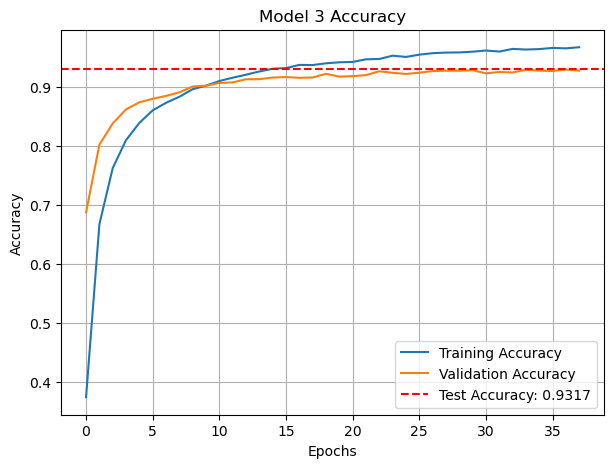

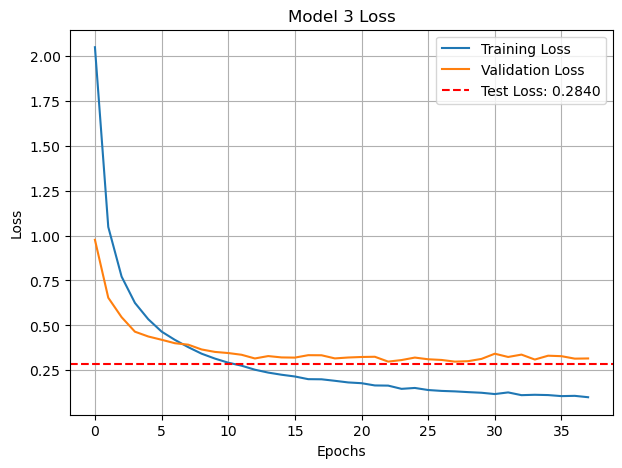

In [165]:
plot_training_results(history3, test_accuracy_3, test_loss_3, 3)

In [40]:
predicted_classes_3, true_classes_3 = evaluate_predictions(
    model3,
    paired_images_test,
    paired_labels_test,  
    top_n=20
)

313/313 [==============================] - 1s 2ms/step
Predicted Classes: [12 12  6  0  5  7 10 14  8 15 10  7 16 12  8 12 12 16 13 11]
True Classes: [12 12  6  0  5  7 10 14  8 15 10  7 16 12  8 12 16 16  7 11]


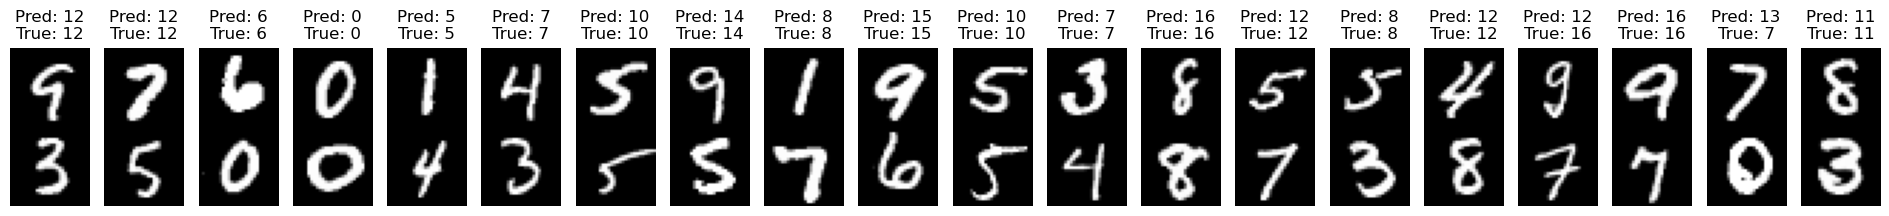

In [41]:
plot_predictions(
    paired_images_test_32,
    predicted_classes_3,
    true_classes_3,
    num_images=20
)

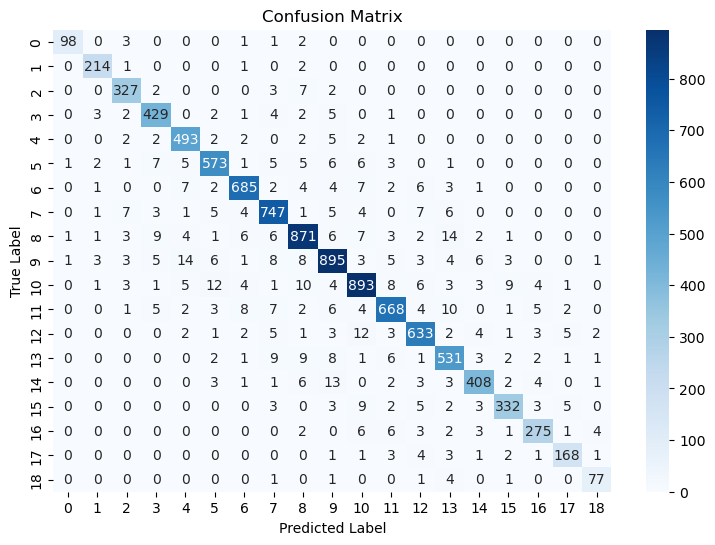

In [42]:
plot_confusion_matrix(true_classes_3, predicted_classes_3)

In [174]:
# Saving best model
# model3.save('best_performing_nn.h5')
# with open('training_history_best_model.json', 'w') as file:
#     json.dump(history3.history, file)
# best_model_weights = model3.save_weights("weights_best_model.h5")

# $\text{Load the best model}$

In [46]:
# Load the saved model
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(43)
model_best = tf.keras.models.load_model('best_model.h5') 
model_best.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 56, 28)]          0         
                                                                 
 flatten_194 (Flatten)       (None, 1568)              0         
                                                                 
 dense_687 (Dense)           (None, 295)               462855    
                                                                 
 batch_normalization_1 (Batc  (None, 295)              1180      
 hNormalization)                                                 
                                                                 
 dropout_493 (Dropout)       (None, 295)               0         
                                                                 
 dense_688 (Dense)           (None, 500)               148000    
                                                           

In [47]:
with open('training_history_best_model.json', 'r') as file:
    history_best = json.load(file)

In [48]:
test_loss_best, test_accuracy_best = model_best.evaluate(paired_images_test_32, paired_labels_test_encode)

# Print test accuracy
print(f"Test Loss: {test_loss_best}")
print(f"Test Accuracy: {test_accuracy_best}")

313/313 [==============================] - 1s 2ms/step - loss: 0.2840 - accuracy: 0.9317
Test Loss: 0.2840191423892975
Test Accuracy: 0.9316999912261963


In [49]:
# loading weights
weights_best = model_best.get_weights()
for i, weight in enumerate(weights_best):
    print(f"Weight {i}: {weight}")


Weight 0: [[-0.04287384 -0.04035679 -0.01736544 ...  0.0122165   0.01640085
  -0.02786626]
 [-0.0013791   0.00803981 -0.00202079 ... -0.03599418 -0.02145391
  -0.05317025]
 [-0.04491277 -0.05093081  0.05604783 ... -0.01467999  0.03408004
  -0.02292969]
 ...
 [-0.02312821 -0.03256595 -0.00392995 ... -0.01107953 -0.01637825
   0.01796879]
 [ 0.02700211  0.04416088 -0.00665407 ...  0.01865616 -0.01619035
   0.02257885]
 [-0.03291414 -0.0349738  -0.04706064 ...  0.04295911  0.04619298
  -0.02186938]]
Weight 1: [ 0.01358671  0.03811804  0.02253924 -0.16897832 -0.11561549  0.09038827
 -0.05159058 -0.00719632 -0.14930642 -0.01682716 -0.01643067  0.05481508
  0.02342532  0.00989083  0.02058251  0.16524166 -0.03200392 -0.01131975
 -0.03433293  0.05162777  0.03515148 -0.0113594  -0.07504737 -0.06389752
 -0.22580858 -0.09103731  0.12592575  0.02214318  0.01225701 -0.02451182
 -0.00109752 -0.00509518  0.00503269  0.06994716  0.0576099   0.06298047
 -0.10543878  0.05713225 -0.11821771  0.03409945 -

In [57]:
model_best.load_weights("weights_best_model.h5")
weights_best = model_best.get_weights()
print(weights_best)


[array([[-0.04287384, -0.04035679, -0.01736544, ...,  0.0122165 ,
         0.01640085, -0.02786626],
       [-0.0013791 ,  0.00803981, -0.00202079, ..., -0.03599418,
        -0.02145391, -0.05317025],
       [-0.04491277, -0.05093081,  0.05604783, ..., -0.01467999,
         0.03408004, -0.02292969],
       ...,
       [-0.02312821, -0.03256595, -0.00392995, ..., -0.01107953,
        -0.01637825,  0.01796879],
       [ 0.02700211,  0.04416088, -0.00665407, ...,  0.01865616,
        -0.01619035,  0.02257885],
       [-0.03291414, -0.0349738 , -0.04706064, ...,  0.04295911,
         0.04619298, -0.02186938]], dtype=float32), array([ 0.01358671,  0.03811804,  0.02253924, -0.16897832, -0.11561549,
        0.09038827, -0.05159058, -0.00719632, -0.14930642, -0.01682716,
       -0.01643067,  0.05481508,  0.02342532,  0.00989083,  0.02058251,
        0.16524166, -0.03200392, -0.01131975, -0.03433293,  0.05162777,
        0.03515148, -0.0113594 , -0.07504737, -0.06389752, -0.22580858,
       -0.

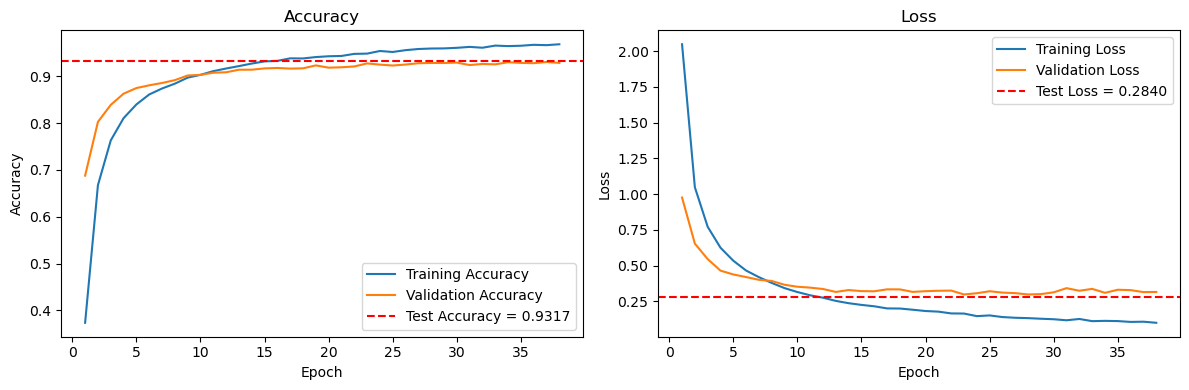

In [58]:
epochs = range(1, len(history_best['accuracy']) + 1)

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history_best['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_best['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy_best, color='r', linestyle='--', label=f'Test Accuracy = {test_accuracy_best:.4f}')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history_best['loss'], label='Training Loss')
plt.plot(epochs, history_best['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss_best, color='r', linestyle='--', label=f'Test Loss = {test_loss_best:.4f}')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# $\text{tSNE distribution in embedding layer \& on input data}$ 

In [166]:
embedding_layer = model3.layers[-3].output 
embedding_model = Model(inputs=model3.input, outputs=embedding_layer)

1500/1500 [==============================] - 6s 3ms/step


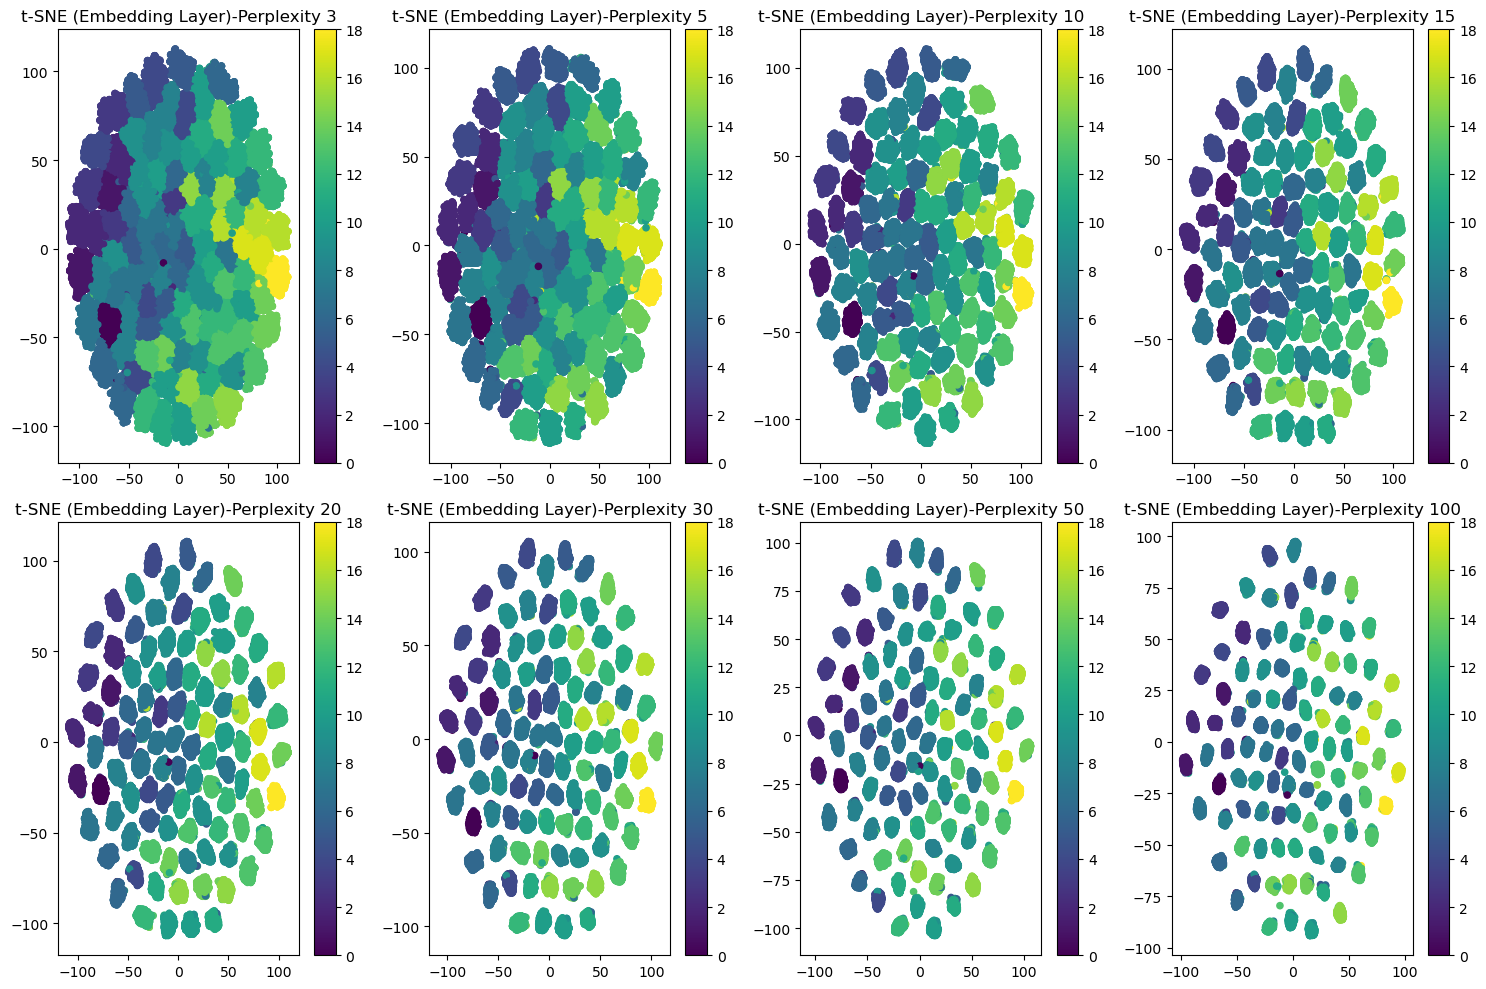

In [169]:
# List of perplexity values to test
perplexities = [3, 5, 10, 15, 20, 30, 50, 100]
embeddings = embedding_model.predict(paired_images_train_32)

# Create a figure for plotting
plt.figure(figsize=(15, 10))
# Loop through each perplexity value and create a t-SNE plot
for perplexity in perplexities:
    tsne_embeddings = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(embeddings)

    # Create a scatter plot for t-SNE embeddings
    plt.subplot(2, 4, perplexities.index(perplexity) + 1)  # Arranging subplots in a grid (2 rows, 4 columns)
    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=paired_labels_train, cmap='viridis', s=20)
    plt.colorbar()
    plt.title(f"t-SNE (Embedding Layer)-Perplexity {perplexity}")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
#91m

In [170]:
# Apply t-SNE directly on the input data (paired_images_train_32)
tsne_input = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(paired_images_train_32.reshape(paired_images_train_32.shape[0], -1))  # Flatten the input images
#16m

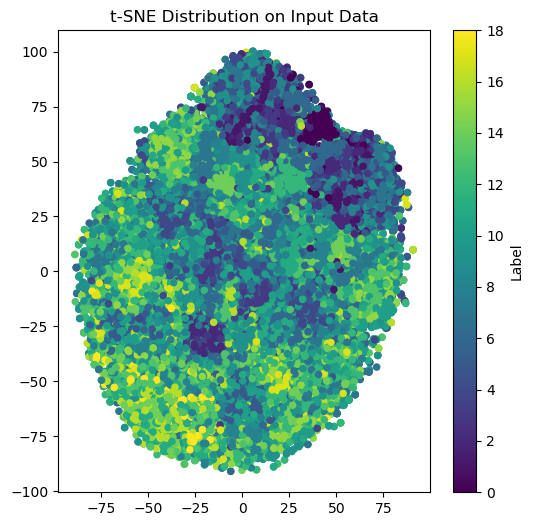

In [175]:
plt.figure(figsize=(6, 6))
scatter = plt.scatter(tsne_input[:, 0], tsne_input[:, 1], c=paired_labels_train, cmap='viridis', s=20)
plt.colorbar(scatter, label='Label')
plt.title('t-SNE Distribution on Input Data')
plt.show()

# $\text{Flattening images}$

In [24]:
X_train_flat = flatten_images(paired_images_train_32)
X_val_flat = flatten_images(paired_images_val_32)
X_test_flat = flatten_images(paired_images_test_32)

In [25]:
# Integer labels 
y_train_int = paired_labels_train
y_val_int   = paired_labels_val
y_test_int  = paired_labels_test

# $\text{Support Vector Machine (SVM)}$

In [31]:
svc = SVC(kernel='rbf', gamma='auto', verbose=True)
svc.fit(X_train_flat, y_train_int)
#85mins

[LibSVM]

SVC(gamma='auto', verbose=True)

In [32]:
y_train_pred = svc.predict(X_train_flat)
y_test_pred = svc.predict(X_test_flat)
#87mins 

In [33]:
test_accuracy = accuracy_score(y_test_int, y_test_pred)
training_accuracy  = accuracy_score(y_train_int,y_train_pred)

In [34]:
print(f'Train Accuracy: {training_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 37.14%
Test Accuracy: 34.77%


## $\text{Optuna for hyperparameter tuning: training with 10\% of the training data}$ 

In [27]:
X_train_flat_subset, y_train_int_subset = sequential_sample(X_train_flat, y_train_int, 4800)  # 10% of 48000 (size of training set)

In [28]:
print(f"X_train_flat_subset: {len(X_train_flat_subset)}, y_train_int_subset: {len(y_train_int_subset)}")

X_train_flat_subset: 4800, y_train_int_subset: 4800


In [29]:
# Initialize the DataFrame to store results
results = []

# Define the objective function for Optuna
def objective_svm(trial):
    # Suggest values for C, gamma, and kernel
    C = trial.suggest_float('C', 0.01, 100, log=True)  # Log-uniform distribution for C
    gamma = trial.suggest_categorical('gamma', ['auto', 'scale', 0.01, 0.1, 1, 10, 100])  # Categorical distribution for gamma
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])    # Categorical distribution for kernel

    # Create the SVM model with the suggested hyperparameters
    model = SVC(C=C, gamma=gamma, kernel=kernel)
    
    # Train the model
    model.fit(X_train_flat_subset, y_train_int_subset)

    # Compute training accuracy
    train_predictions = model.predict(X_train_flat_subset)
    train_accuracy = accuracy_score(y_train_int_subset, train_predictions)

    # Compute validation accuracy
    val_predictions = model.predict(X_val_flat)
    val_accuracy = accuracy_score(y_val_int, val_predictions)
    
    # Compute test accuracy
    test_predictions = model.predict(X_test_flat)
    test_accuracy = accuracy_score(y_test_int, test_predictions)

    # Print the accuracies
    print(f"Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}")
    
    # Return the test accuracy for Optuna to maximize
    return test_accuracy

In [44]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

study = optuna.create_study(study_name="svm_1",direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))  
study.optimize(objective_svm, n_trials=15)
#57mins to run

[I 2024-12-14 09:59:30,261] A new study created in memory with name: svm_1
[I 2024-12-14 10:03:54,348] Trial 0 finished with value: 0.0969 and parameters: {'C': 0.31489116479568624, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.0969.


Train Accuracy: 0.10083333333333333, Val Accuracy: 0.10316666666666667, Test Accuracy: 0.0969


[I 2024-12-14 10:07:47,956] Trial 1 finished with value: 0.2253 and parameters: {'C': 21.368329072358772, 'gamma': 1, 'kernel': 'linear'}. Best is trial 1 with value: 0.2253.


Train Accuracy: 1.0, Val Accuracy: 0.21975, Test Accuracy: 0.2253


[I 2024-12-14 10:13:19,616] Trial 2 finished with value: 0.1057 and parameters: {'C': 0.6672367170464207, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 1 with value: 0.2253.


Train Accuracy: 0.118125, Val Accuracy: 0.11141666666666666, Test Accuracy: 0.1057


[I 2024-12-14 10:17:28,111] Trial 3 finished with value: 0.5345 and parameters: {'C': 0.1653693718282443, 'gamma': 100, 'kernel': 'poly'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 1.0, Val Accuracy: 0.5175, Test Accuracy: 0.5345


[I 2024-12-14 10:21:16,701] Trial 4 finished with value: 0.1093 and parameters: {'C': 1.5375920235481764, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 0.1475, Val Accuracy: 0.10558333333333333, Test Accuracy: 0.1093


[I 2024-12-14 10:25:09,790] Trial 5 finished with value: 0.3437 and parameters: {'C': 0.358681649862755, 'gamma': 'scale', 'kernel': 'poly'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 0.6447916666666667, Val Accuracy: 0.325, Test Accuracy: 0.3437


[I 2024-12-14 10:28:58,517] Trial 6 finished with value: 0.2484 and parameters: {'C': 0.01052176186845113, 'gamma': 'auto', 'kernel': 'linear'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 0.46041666666666664, Val Accuracy: 0.23425, Test Accuracy: 0.2484


[I 2024-12-14 10:34:22,612] Trial 7 finished with value: 0.0969 and parameters: {'C': 0.17535949529764422, 'gamma': 0.1, 'kernel': 'rbf'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 0.10083333333333333, Val Accuracy: 0.10316666666666667, Test Accuracy: 0.0969


[I 2024-12-14 10:38:21,422] Trial 8 finished with value: 0.2258 and parameters: {'C': 1.2329098365270517, 'gamma': 1, 'kernel': 'linear'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 0.9972916666666667, Val Accuracy: 0.21983333333333333, Test Accuracy: 0.2258


[I 2024-12-14 10:43:31,169] Trial 9 finished with value: 0.0969 and parameters: {'C': 0.08226074946221039, 'gamma': 0.1, 'kernel': 'rbf'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 0.10083333333333333, Val Accuracy: 0.10316666666666667, Test Accuracy: 0.0969


[I 2024-12-14 10:47:15,004] Trial 10 finished with value: 0.5345 and parameters: {'C': 12.851342655040481, 'gamma': 100, 'kernel': 'poly'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 1.0, Val Accuracy: 0.5175, Test Accuracy: 0.5345


[I 2024-12-14 10:49:59,908] Trial 11 finished with value: 0.5345 and parameters: {'C': 53.59957765771794, 'gamma': 100, 'kernel': 'poly'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 1.0, Val Accuracy: 0.5175, Test Accuracy: 0.5345


[I 2024-12-14 10:52:17,607] Trial 12 finished with value: 0.5345 and parameters: {'C': 8.661545370938063, 'gamma': 100, 'kernel': 'poly'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 1.0, Val Accuracy: 0.5175, Test Accuracy: 0.5345


[I 2024-12-14 10:54:35,401] Trial 13 finished with value: 0.5345 and parameters: {'C': 3.757084358753148, 'gamma': 100, 'kernel': 'poly'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 1.0, Val Accuracy: 0.5175, Test Accuracy: 0.5345


[I 2024-12-14 10:56:50,855] Trial 14 finished with value: 0.5345 and parameters: {'C': 0.03790453593833557, 'gamma': 10, 'kernel': 'poly'}. Best is trial 3 with value: 0.5345.


Train Accuracy: 1.0, Val Accuracy: 0.51775, Test Accuracy: 0.5345


In [46]:
print(f"Best hyperparameters: {study.best_params}")
print(f"Best accuracy: {study.best_value}")

Best hyperparameters: {'C': 0.1653693718282443, 'gamma': 100, 'kernel': 'poly'}
Best accuracy: 0.5345


In [ ]:
# training with full data again using the best hyperparameters obtained through optuna
svc = SVC(kernel='poly',C= 0.1653693718282443, gamma=100,verbose=True, random_state=43)
svc.fit(X_train_flat, y_train_int)

[LibSVM]

SVC(C=0.1653693718282443, gamma=100, kernel='poly', random_state=43,
    verbose=True)

In [49]:
y_train_pred = svc.predict(X_train_flat)
y_test_pred = svc.predict(X_test_flat)

In [50]:
test_accuracy = accuracy_score(y_test_int, y_test_pred)
training_accuracy  = accuracy_score(y_train_int,y_train_pred)

In [51]:
print(f'Train Accuracy: {training_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 100.00%
Test Accuracy: 78.45%


# $\text{Random Forest}$

In [ ]:
RndFrstClass = RandomForestClassifier()
RndFrstClass.fit(X_train_flat, y_train_int) 
# 1min

RandomForestClassifier()

In [58]:
train_predictions = RndFrstClass.predict(X_train_flat) 
test_predictions = RndFrstClass.predict(X_test_flat)

In [59]:
train_accuracy = accuracy_score(y_train_int, train_predictions)
test_accuracy = accuracy_score(y_test_int, test_predictions)

In [60]:
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.7463


## $\text{Exploring the effect of different maximum depths}$ 

In [61]:
max_depth_range = range(1, 27) 

# Initialize lists to store the accuracies for each max_depth value
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Iterate over the max_depth values and train the RandomForestClassifier
for max_depth in max_depth_range:
    # Initialize the classifier with the current max_depth
    RndFrstClass = RandomForestClassifier(max_depth=max_depth, random_state=42)
    
    # Fit the model on the training data
    RndFrstClass.fit(X_train_flat, y_train_int)
    
    # Make predictions on training, validation, and test sets
    train_preds = RndFrstClass.predict(X_train_flat)
    val_preds = RndFrstClass.predict(X_val_flat) 
    test_preds = RndFrstClass.predict(X_test_flat)  

    # Calculate accuracy for each set
    train_accuracy = accuracy_score(y_train_int, train_preds)
    val_accuracy = accuracy_score(y_val_int, val_preds)  
    test_accuracy = accuracy_score(y_test_int, test_preds)  

    # Append the accuracies to the respective lists
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

#30m 

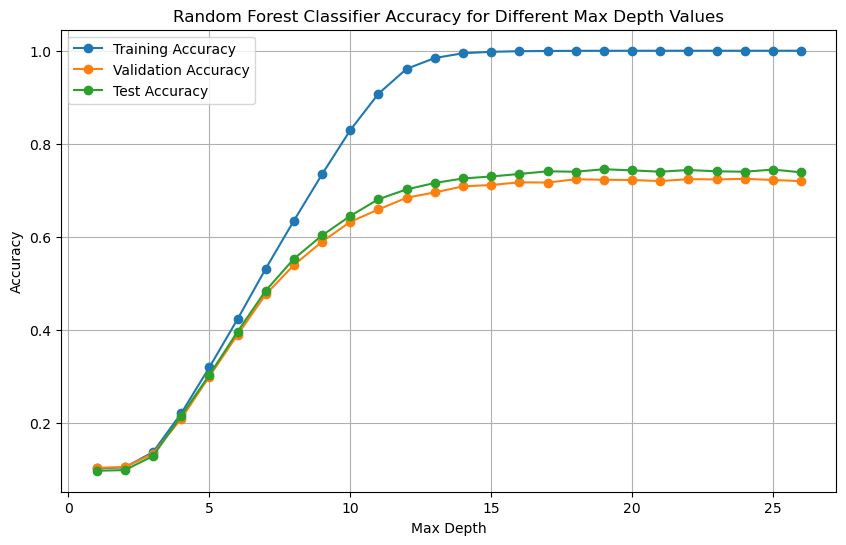

In [62]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(max_depth_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(max_depth_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Accuracy for Different Max Depth Values')
plt.legend()
plt.grid(True)
plt.show()

## $\text{Optuna for Hyperparameter Tuning (Random Forests)}$ 

In [30]:
def objective_rf(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)  # Number of trees
    max_depth = trial.suggest_int('max_depth', 5, 9)  # Maximum depth of trees
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Min samples to split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Min samples for leaf nodes
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])  # Number of features to consider

    # Create and train the Random Forest Classifier
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Train the model on the paired training set
    model.fit(X_train_flat, y_train_int)


    # Make predictions on the training set, validation set, and test set
    y_train_pred = model.predict(X_train_flat)
    y_val_pred = model.predict(X_val_flat)
    y_test_pred = model.predict(X_test_flat)
    
    # Compute accuracy on the training, validation, and test set
    train_accuracy = accuracy_score(y_train_int, y_train_pred)
    val_accuracy = accuracy_score(y_val_int, y_val_pred)
    test_accuracy = accuracy_score(y_test_int, y_test_pred)
    
    # Print train, validation, and test accuracies for each trial
    print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    
    return test_accuracy

In [39]:
# Create the Optuna study to maximize the validation accuracy
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
study = optuna.create_study(study_name="random_forest",direction='maximize',sampler=optuna.samplers.TPESampler(seed=14)) # We want to maximize the validation accuracy
study.optimize(objective_rf, n_trials=10) 
# 3mins to run

[I 2024-12-18 07:13:21,419] A new study created in memory with name: random_forest
[I 2024-12-18 07:13:29,785] Trial 0 finished with value: 0.465 and parameters: {'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.465.


Train Accuracy: 0.5486, Validation Accuracy: 0.4517, Test Accuracy: 0.4650


[I 2024-12-18 07:13:59,987] Trial 1 finished with value: 0.3943 and parameters: {'n_estimators': 76, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.465.


Train Accuracy: 0.4205, Validation Accuracy: 0.3844, Test Accuracy: 0.3943


[I 2024-12-18 07:14:24,676] Trial 2 finished with value: 0.3041 and parameters: {'n_estimators': 77, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.465.


Train Accuracy: 0.3204, Validation Accuracy: 0.2994, Test Accuracy: 0.3041


[I 2024-12-18 07:14:42,779] Trial 3 finished with value: 0.4682 and parameters: {'n_estimators': 88, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.4682.


Train Accuracy: 0.5539, Validation Accuracy: 0.4550, Test Accuracy: 0.4682


[I 2024-12-18 07:14:56,227] Trial 4 finished with value: 0.3184 and parameters: {'n_estimators': 84, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 3 with value: 0.4682.


Train Accuracy: 0.3484, Validation Accuracy: 0.3195, Test Accuracy: 0.3184


[I 2024-12-18 07:15:08,774] Trial 5 finished with value: 0.2216 and parameters: {'n_estimators': 95, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 3 with value: 0.4682.


Train Accuracy: 0.2389, Validation Accuracy: 0.2221, Test Accuracy: 0.2216


[I 2024-12-18 07:15:24,528] Trial 6 finished with value: 0.5197 and parameters: {'n_estimators': 70, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 6 with value: 0.5197.


Train Accuracy: 0.6543, Validation Accuracy: 0.5068, Test Accuracy: 0.5197


[I 2024-12-18 07:15:33,891] Trial 7 finished with value: 0.2213 and parameters: {'n_estimators': 68, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 6 with value: 0.5197.


Train Accuracy: 0.2407, Validation Accuracy: 0.2266, Test Accuracy: 0.2213


[I 2024-12-18 07:15:52,842] Trial 8 finished with value: 0.5267 and parameters: {'n_estimators': 87, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 8 with value: 0.5267.


Train Accuracy: 0.6674, Validation Accuracy: 0.5117, Test Accuracy: 0.5267


[I 2024-12-18 07:16:08,462] Trial 9 finished with value: 0.3175 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 8 with value: 0.5267.


Train Accuracy: 0.3506, Validation Accuracy: 0.3217, Test Accuracy: 0.3175


In [40]:
print(f"Best hyperparameters: {study.best_params}")
print(f"Best accuracy: {study.best_value}")

Best hyperparameters: {'n_estimators': 87, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}
Best accuracy: 0.5267


In [43]:
RndFrstClass_optuna = RandomForestClassifier(n_estimators=87, max_depth=9, min_samples_split=5, min_samples_leaf=3, max_features='log2')
RndFrstClass_optuna.fit(X_train_flat, y_train_int) 

RandomForestClassifier(max_depth=9, max_features='log2', min_samples_leaf=3,
                       min_samples_split=5, n_estimators=87)

In [44]:
train_predictions_optuna = RndFrstClass_optuna.predict(X_train_flat)
val_predictions_optuna = RndFrstClass_optuna.predict(X_val_flat)  
test_predictions_optuna = RndFrstClass_optuna.predict(X_test_flat)

train_accuracy_optuna = accuracy_score(y_train_int, train_predictions_optuna)
val_accuracy_optuna = accuracy_score(y_val_int, val_predictions_optuna) 
test_accuracy_optuna = accuracy_score(y_test_int, test_predictions_optuna)

print(f"Training Accuracy: {train_accuracy_optuna:.4f}")
print(f"Validation Accuracy: {val_accuracy_optuna:.4f}")
print(f"Test Accuracy: {test_accuracy_optuna:.4f}")

Training Accuracy: 0.6751
Validation Accuracy: 0.5142
Test Accuracy: 0.5254


# $\text{Weak Linear Classifier}$

In [ ]:
# Training a logistic regression model on the full data to assess its performance in general 
logistic_full = LogisticRegression(C=1e15,solver='sag', penalty='l2',tol=0.01, random_state=43)
logistic_full.fit(X_train_flat, y_train_int)
#4mins 

LogisticRegression(C=1000000000000000.0, random_state=43, solver='sag',
                   tol=0.01)

In [46]:
y_pred_test  = logistic_full.predict(X_test_flat)
y_pred_train = logistic_full.predict(X_train_flat)

In [47]:
train_accuracy= accuracy_score(y_train_int, y_pred_train)
test_accuarcy = accuracy_score(y_test_int, y_pred_test)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuarcy * 100:.2f}%")


Train Accuracy: 34.54%
Test Accuracy: 21.61%


## $\text{Optuna for Hyperparameter Tuning (Logistic Regression)}$ 

In [52]:
# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    c = trial.suggest_float("C", 1e10, 1e20)      # Inverse of regularization strength
    solver = trial.suggest_categorical("solver", ["lbfgs", "saga", "newton-cg", "sag"])
    tol = trial.suggest_float("tol", 1e-6, 1e-1)  # Tolerance for stopping criteria

    # Logistic regression model with trial-specific hyperparameters
    clf = LogisticRegression(C=c, solver=solver, tol=tol)

    # Train the model
    clf.fit(X_train_flat, y_train_int)

    # Training predictions and loss
    y_train_pred = clf.predict(X_train_flat)
    y_train_proba = clf.predict_proba(X_train_flat)
    train_loss = log_loss(y_train_int, y_train_proba)
    train_accuracy = accuracy_score(y_train_int, y_train_pred)

    # Validation predictions and loss
    y_val_pred = clf.predict(X_val_flat)
    y_val_proba = clf.predict_proba(X_val_flat)
    val_loss = log_loss(y_val_int, y_val_proba)
    val_accuracy = accuracy_score(y_val_int, y_val_pred)


    # Test predictions and loss
    y_test_pred = clf.predict(X_test_flat)
    y_test_proba = clf.predict_proba(X_test_flat)
    test_loss = log_loss(y_test_int, y_test_proba)
    test_accuracy = accuracy_score(y_test_int, y_test_pred)

    # Print metrics for this trial
    print(f"Trial {trial.number}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Test Loss:  {test_loss:.4f}, Test Accuracy:  {test_accuracy:.4f}")

    # Returning test accuracy for Optuna to maximize 
    return test_accuracy


In [55]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

study_log= optuna.create_study(study_name='study_logistic', direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))  # Maximize accuracy
study_log.optimize(objective, n_trials=15)  
#10mins to run

[I 2024-12-18 08:22:44,196] A new study created in memory with name: study_logistic
[I 2024-12-18 08:22:46,990] Trial 0 finished with value: 0.1204 and parameters: {'C': 3.745401189099084e+19, 'solver': 'lbfgs', 'tol': 0.015600296039099928}. Best is trial 0 with value: 0.1204.


Trial 0:
  Train Loss: 2.7622, Train Accuracy: 0.1137
  Validation Loss: 2.7595, Validation Accuracy: 0.1126
  Test Loss:  2.7602, Test Accuracy:  0.1204


[I 2024-12-18 08:22:48,848] Trial 1 finished with value: 0.0105 and parameters: {'C': 5.808361226239109e+18, 'solver': 'lbfgs', 'tol': 0.09699101530634728}. Best is trial 0 with value: 0.1204.


Trial 1:
  Train Loss: 2.9444, Train Accuracy: 0.0102
  Validation Loss: 2.9444, Validation Accuracy: 0.0092
  Test Loss:  2.9444, Test Accuracy:  0.0105


[I 2024-12-18 08:23:46,133] Trial 2 finished with value: 0.2165 and parameters: {'C': 8.324426408171776e+19, 'solver': 'sag', 'tol': 0.05247611840679216}. Best is trial 2 with value: 0.2165.


Trial 2:
  Train Loss: 1.9605, Train Accuracy: 0.3257
  Validation Loss: 2.2524, Validation Accuracy: 0.2156
  Test Loss:  2.2134, Test Accuracy:  0.2165


[I 2024-12-18 08:26:38,297] Trial 3 finished with value: 0.221 and parameters: {'C': 4.3194501869892125e+19, 'solver': 'saga', 'tol': 0.03663681796752588}. Best is trial 3 with value: 0.221.


Trial 3:
  Train Loss: 1.9670, Train Accuracy: 0.3241
  Validation Loss: 2.2361, Validation Accuracy: 0.2152
  Test Loss:  2.1975, Test Accuracy:  0.2210


[I 2024-12-18 08:26:43,195] Trial 4 finished with value: 0.2002 and parameters: {'C': 4.560699842714289e+19, 'solver': 'lbfgs', 'tol': 0.004645994821587052}. Best is trial 3 with value: 0.221.


Trial 4:
  Train Loss: 2.2487, Train Accuracy: 0.2214
  Validation Loss: 2.3067, Validation Accuracy: 0.1945
  Test Loss:  2.2643, Test Accuracy:  0.2002


[I 2024-12-18 08:27:44,154] Trial 5 finished with value: 0.2149 and parameters: {'C': 6.0754485194068386e+19, 'solver': 'sag', 'tol': 0.080839926414298}. Best is trial 3 with value: 0.221.


Trial 5:
  Train Loss: 1.9664, Train Accuracy: 0.3244
  Validation Loss: 2.2501, Validation Accuracy: 0.2121
  Test Loss:  2.2122, Test Accuracy:  0.2149


[I 2024-12-18 08:29:49,123] Trial 6 finished with value: 0.2219 and parameters: {'C': 3.046137692429093e+19, 'solver': 'saga', 'tol': 0.04951819583421691}. Best is trial 6 with value: 0.2219.


Trial 6:
  Train Loss: 1.9844, Train Accuracy: 0.3189
  Validation Loss: 2.2285, Validation Accuracy: 0.2153
  Test Loss:  2.1910, Test Accuracy:  0.2219


[I 2024-12-18 08:29:51,675] Trial 7 finished with value: 0.0105 and parameters: {'C': 3.4388521211779543e+18, 'solver': 'lbfgs', 'tol': 0.052007282049759906}. Best is trial 6 with value: 0.2219.


Trial 7:
  Train Loss: 2.9444, Train Accuracy: 0.0102
  Validation Loss: 2.9444, Validation Accuracy: 0.0092
  Test Loss:  2.9444, Test Accuracy:  0.0105


[I 2024-12-18 08:30:37,455] Trial 8 finished with value: 0.2246 and parameters: {'C': 5.467102793886086e+19, 'solver': 'saga', 'tol': 0.08948284021541446}. Best is trial 8 with value: 0.2246.


Trial 8:
  Train Loss: 2.0274, Train Accuracy: 0.3035
  Validation Loss: 2.2221, Validation Accuracy: 0.2134
  Test Loss:  2.1857, Test Accuracy:  0.2246


[I 2024-12-18 08:30:39,606] Trial 9 finished with value: 0.0969 and parameters: {'C': 5.978999788512951e+19, 'solver': 'lbfgs', 'tol': 0.03253370774599567}. Best is trial 8 with value: 0.2246.


Trial 9:
  Train Loss: 2.7927, Train Accuracy: 0.1020
  Validation Loss: 2.7893, Validation Accuracy: 0.1032
  Test Loss:  2.7929, Test Accuracy:  0.0969


[I 2024-12-18 08:30:40,178] Trial 10 finished with value: 0.0105 and parameters: {'C': 9.451365442358732e+19, 'solver': 'newton-cg', 'tol': 0.0799517167273819}. Best is trial 8 with value: 0.2246.


Trial 10:
  Train Loss: 2.9444, Train Accuracy: 0.0102
  Validation Loss: 2.9444, Validation Accuracy: 0.0092
  Test Loss:  2.9444, Test Accuracy:  0.0105


[I 2024-12-18 08:31:18,993] Trial 11 finished with value: 0.2241 and parameters: {'C': 2.4962533091622695e+19, 'solver': 'saga', 'tol': 0.06902501710984096}. Best is trial 8 with value: 0.2246.


Trial 11:
  Train Loss: 2.0163, Train Accuracy: 0.3053
  Validation Loss: 2.2209, Validation Accuracy: 0.2150
  Test Loss:  2.1851, Test Accuracy:  0.2241


[I 2024-12-18 08:31:51,571] Trial 12 finished with value: 0.2215 and parameters: {'C': 2.233012291746649e+19, 'solver': 'saga', 'tol': 0.07542670184401244}. Best is trial 8 with value: 0.2246.


Trial 12:
  Train Loss: 2.0269, Train Accuracy: 0.3023
  Validation Loss: 2.2242, Validation Accuracy: 0.2185
  Test Loss:  2.1851, Test Accuracy:  0.2215


[I 2024-12-18 08:32:26,467] Trial 13 finished with value: 0.2241 and parameters: {'C': 6.437127366594522e+19, 'solver': 'saga', 'tol': 0.09458102618765137}. Best is trial 8 with value: 0.2246.


Trial 13:
  Train Loss: 2.0393, Train Accuracy: 0.2990
  Validation Loss: 2.2232, Validation Accuracy: 0.2164
  Test Loss:  2.1869, Test Accuracy:  0.2241


[I 2024-12-18 08:33:10,561] Trial 14 finished with value: 0.2255 and parameters: {'C': 1.9240492945332605e+19, 'solver': 'saga', 'tol': 0.06767234584828175}. Best is trial 14 with value: 0.2255.


Trial 14:
  Train Loss: 2.0065, Train Accuracy: 0.3114
  Validation Loss: 2.2222, Validation Accuracy: 0.2153
  Test Loss:  2.1857, Test Accuracy:  0.2255


In [57]:
for trial in sorted(study_log.trials, key=lambda trial: trial.value, reverse=True):
    print(f"Trial {trial.number}: Value={trial.value}, Params={trial.params}") # from highest to lowest accuracy

Trial 14: Value=0.2255, Params={'C': 1.9240492945332605e+19, 'solver': 'saga', 'tol': 0.06767234584828175}
Trial 8: Value=0.2246, Params={'C': 5.467102793886086e+19, 'solver': 'saga', 'tol': 0.08948284021541446}
Trial 11: Value=0.2241, Params={'C': 2.4962533091622695e+19, 'solver': 'saga', 'tol': 0.06902501710984096}
Trial 13: Value=0.2241, Params={'C': 6.437127366594522e+19, 'solver': 'saga', 'tol': 0.09458102618765137}
Trial 6: Value=0.2219, Params={'C': 3.046137692429093e+19, 'solver': 'saga', 'tol': 0.04951819583421691}
Trial 12: Value=0.2215, Params={'C': 2.233012291746649e+19, 'solver': 'saga', 'tol': 0.07542670184401244}
Trial 3: Value=0.221, Params={'C': 4.3194501869892125e+19, 'solver': 'saga', 'tol': 0.03663681796752588}
Trial 2: Value=0.2165, Params={'C': 8.324426408171776e+19, 'solver': 'sag', 'tol': 0.05247611840679216}
Trial 5: Value=0.2149, Params={'C': 6.0754485194068386e+19, 'solver': 'sag', 'tol': 0.080839926414298}
Trial 4: Value=0.2002, Params={'C': 4.56069984271428

In [58]:
best_trial = study_log.best_trial
print("\nBest Trial:")
print(f"  Trial Number: {best_trial.number}")
print(f"  Best Hyperparameters: {best_trial.params}")
print(f"  Best Test Accuracy: {best_trial.value* 100:.2f}%")


Best Trial:
  Trial Number: 14
  Best Hyperparameters: {'C': 1.9240492945332605e+19, 'solver': 'saga', 'tol': 0.06767234584828175}
  Best Test Accuracy: 22.55%


In [69]:
logistic_full_opt = LogisticRegression(C= 1.9240492945332605e+19,solver='saga',tol=0.06767234584828175, random_state=45)
logistic_full_opt.fit(X_train_flat, y_train_int)
#42secs to run

LogisticRegression(C=1.9240492945332605e+19, random_state=45, solver='saga',
                   tol=0.06767234584828175)

In [70]:
y_pred_test_opt  = logistic_full_opt.predict(X_test_flat)
y_pred_train_opt = logistic_full_opt.predict(X_train_flat)
y_pred_val_opt   = logistic_full_opt.predict(X_val_flat)

In [71]:
train_accuracy= accuracy_score(y_train_int, y_pred_train_opt)
val_accuracy = accuracy_score(y_val_int, y_pred_val_opt)
test_accuarcy = accuracy_score(y_test_int, y_pred_test_opt)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuarcy * 100:.2f}%")

Train Accuracy: 30.67%
Validation Accuracy: 21.82%
Test Accuracy: 22.60%


# $\text{Logistic Regression - Two Approaches}$

In [152]:
def weak_linear_classifier(X_train_upper, X_train_lower, y_train_upper, y_train_lower, 
                                         X_test_upper, X_test_lower, y_test_sum, 
                                         X_train_paired_flat, X_test_paired_flat, 
                                         y_train_sum, sample_sizes, random_state=45):
    """
    Train and compare separate logistic regression models for split images versus a combined model.

    Parameters:
    - X_train_upper: Upper training images (not flattened, shape: [n_samples, height, width]).
    - X_train_lower: Lower training images (not flattened, shape: [n_samples, height, width]).
    - y_train_upper: Labels for upper training images.
    - y_train_lower: Labels for lower training images.
    - X_test_upper: Upper test images (not flattened, shape: [n_samples, height, width]).
    - X_test_lower: Lower test images (not flattened, shape: [n_samples, height, width]).
    - y_test_sum: Test labels (sum of the two digits).
    - X_train_paired_flat: Flattened paired training images.
    - X_test_paired_flat: Flattened paired test images.
    - y_train_sum: Labels for the sum of digits for training pairs.
    - sample_sizes: List of training sample sizes to evaluate.
    - random_state: Random seed for reproducibility.

    Returns:
    - results: A dictionary containing accuracies and probabilities for separate and combined models.
    """
    np.random.seed(random_state)
    results = {
        "sample_sizes": [], 
        "accuracy_separate": [], 
        "accuracy_combined": [],
        "separate_probabilities": [], 
        "combined_probabilities": []
    }

    for n_samples in sample_sizes:
        print(f"\nTraining with {n_samples} samples:")

        # Subset the training data
        X_train_upper_subset = X_train_upper[:n_samples].reshape(n_samples, -1)  # Flatten upper training images
        X_train_lower_subset = X_train_lower[:n_samples].reshape(n_samples, -1)  # Flatten lower training images
        y_train_upper_subset = y_train_upper[:n_samples] # take a subset of size n_samples from flattened upper images
        y_train_lower_subset = y_train_lower[:n_samples] # take a subset of size n_samples from flattened lower images


        X_train_paired_subset = X_train_paired_flat[:n_samples]  # Training vertically stacked images already flattened
        y_train_sum_subset = y_train_sum[:n_samples]             # Training labels of vertically stacked images

        # Flatten test data for upper and lower images
        X_test_upper_flat = X_test_upper.reshape(X_test_upper.shape[0], -1)  # Flatten upper test images
        X_test_lower_flat = X_test_lower.reshape(X_test_lower.shape[0], -1)  # Flatten lower test images

        # Train two images (upper and lower) sequentially with the logistic model 
        model_upper = LogisticRegression(C= 1.9240492945332605e+19,solver='saga',tol=0.06767234584828175, random_state=random_state)
        model_lower = LogisticRegression(C= 1.9240492945332605e+19,solver='saga',tol=0.06767234584828175, random_state=random_state)
       
        model_upper.fit(X_train_upper_subset, y_train_upper_subset)
        model_lower.fit(X_train_lower_subset, y_train_lower_subset)

        # Predict probabilities and classes for separate models
        y_test_upper_proba = model_upper.predict_proba(X_test_upper_flat)  # Probabilities for upper images
        y_test_lower_proba = model_upper.predict_proba(X_test_lower_flat)  # Probabilities for lower images
        y_test_upper_pred = model_lower.predict(X_test_upper_flat)  # Predictions for upper images
        y_test_lower_pred = model_lower.predict(X_test_lower_flat)  # Predictions for lower images

        # Sum predictions for final prediction
        y_test_sum_pred_separate = y_test_upper_pred + y_test_lower_pred

#---------------------------------------------------------------------- Second approach
   
        # Train a model on paired (combined) images
        model_combined = LogisticRegression(C= 1.9240492945332605e+19,solver='saga',tol=0.06767234584828175, random_state=random_state)
        model_combined.fit(X_train_paired_subset, y_train_sum_subset)

        # Predict probabilities and classes for the combined model
        y_test_combined_proba = model_combined.predict_proba(X_test_paired_flat)  # Probabilities for combined model
        y_test_sum_pred_combined = model_combined.predict(X_test_paired_flat)  # Predictions for combined model

        # Calculate accuracies
        accuracy_separate = accuracy_score(y_test_sum, y_test_sum_pred_separate)
        accuracy_combined = accuracy_score(y_test_sum, y_test_sum_pred_combined)


       # Store results
        results["sample_sizes"].append(n_samples)
        results["accuracy_separate"].append(accuracy_separate)
        results["accuracy_combined"].append(accuracy_combined)
        results["separate_probabilities"].append((y_test_upper_proba, y_test_lower_proba))  # Tuple of probabilities
        results["combined_probabilities"].append(y_test_combined_proba)

        print(f"Sample Size:{n_samples}, Sequential Accuracy: {accuracy_separate:.4f}, Paired-Images Accuracy: {accuracy_combined:.4f}")
    
    return results


In [153]:
sample_sizes = [50, 100, 500, 1000]
results= weak_linear_classifier(image_1_train, image_2_train, label_1_train, label_2_train, image_1_test, image_2_test, y_test_int, X_train_flat, X_test_flat, y_train_int, sample_sizes, 45)



Training with 50 samples:
Sample Size:50, Sequential Accuracy: 0.2867, Paired-Images Accuracy: 0.1115

Training with 100 samples:
Sample Size:100, Sequential Accuracy: 0.5042, Paired-Images Accuracy: 0.1214

Training with 500 samples:
Sample Size:500, Sequential Accuracy: 0.7058, Paired-Images Accuracy: 0.1419

Training with 1000 samples:
Sample Size:1000, Sequential Accuracy: 0.7750, Paired-Images Accuracy: 0.1579


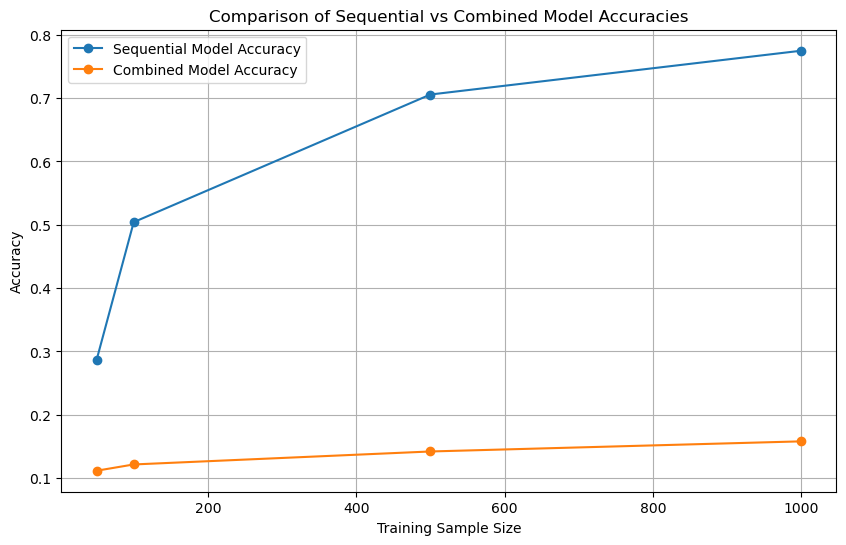

In [154]:
# Extract data
sample_sizes = results["sample_sizes"]
accuracy_separate = results["accuracy_separate"]
accuracy_combined = results["accuracy_combined"]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, accuracy_separate, marker='o', label="Sequential Model Accuracy")
plt.plot(sample_sizes, accuracy_combined, marker='o', label="Combined Model Accuracy")
plt.xlabel("Training Sample Size")
plt.ylabel("Accuracy")
plt.title("Comparison of Sequential vs Combined Model Accuracies")
plt.legend()
plt.grid()
plt.show()

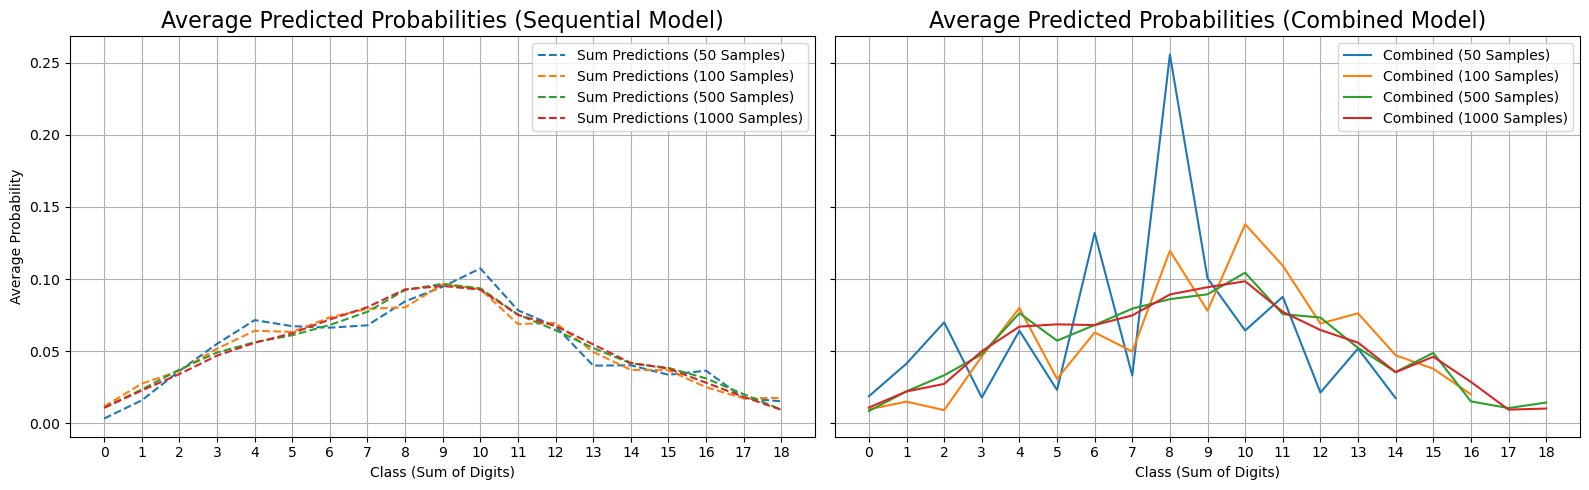

In [160]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Sequential Model (Sum of Predictions)
for idx, n_samples in enumerate(results["sample_sizes"]):
    # Extract probabilities for upper and lower models for every training sample size (50, 100, 500, 1000)
    upper_probs, lower_probs = results["separate_probabilities"][idx] 
    
    # Calculate the sum probabilities (convolution of upper and lower probabilities)
    sum_probs = np.zeros((upper_probs.shape[0], upper_probs.shape[1] + lower_probs.shape[1] - 1)) # upper_probs.shape = (10000, 10)(10000 test samples, 10 classes)
    for i in range(upper_probs.shape[0]):  # Iterate over each test sample (10000 test sample)
        sum_probs[i] = np.convolve(upper_probs[i], lower_probs[i]) 
    
    # Average probabilities across columns (average probability predicted for each class across all test samples)
    avg_sum_probs = np.mean(sum_probs, axis=0)
    
    # Plot summed probabilities
    axes[0].plot(avg_sum_probs, label=f"Sum Predictions ({n_samples} Samples)", linestyle="--")

axes[0].set_xticks(np.arange(0, 19))  # Adjust x-axis ticks to match sum range
axes[0].set_xlabel("Class (Sum of Digits)")
axes[0].set_ylabel("Average Probability")
axes[0].set_title("Average Predicted Probabilities (Sequential Model)", fontsize=16)
axes[0].legend()
axes[0].grid()

# Combined Model Plot
for idx, n_samples in enumerate(results["sample_sizes"]):
    avg_probs_combined = np.mean(results["combined_probabilities"][idx], axis=0)  # Average probs for combined model
    axes[1].plot(avg_probs_combined, label=f"Combined ({n_samples} Samples)", linestyle="-")

axes[1].set_xticks(np.arange(0, 19))  # Adjust x-axis ticks to match sum range
axes[1].set_xlabel("Class (Sum of Digits)")
axes[1].set_title("Average Predicted Probabilities (Combined Model)", fontsize=16)
axes[1].legend()
axes[1].grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
